In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

## **Define Functions for Simulations**

In [5]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        Pss = Pss.squeeze()
        return Pss

In [6]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [7]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5):
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    for c in range(clus):
        marks = all_choices[c*num_marks:(c+1)*num_marks]

        #UPDATE to change either b or beta&gamma
        for m in marks:
            if np.random.rand() < p:
                params[c,m,0] += loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1) #Only in burst size
            else:
                params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                params[c,m,3] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)

    return params,all_choices


In [8]:
def make_counts(clus,n_cells,n_genes,params):
    all_counts = np.zeros((clus*n_cells,n_genes,2))
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
            #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
            #max_domain = [int(i) for i in max_domain]

            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells, Pss)
            all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
            all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]
            
    return all_counts

In [9]:
#No. of cells per k cell 'type'
n_cells = 500
clus = 3

In [10]:
n_genes = 100
num_marks = 10

In [11]:
#Technical sampling params
glob_samp = np.asarray([-7.157894736842105, -1.525])

In [12]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,TNMD,14950,48,23,10,5,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,DPM1,23689,98,38,25,17,10,6,5,5,...,0,0,0,0,0,0,0,0,0,0
2,SCYL3,44637,132,51,20,13,9,7,6,4,...,0,0,0,0,0,0,0,0,0,0
3,TSPAN6,12884,43,18,13,8,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
4,FGR,23122,41,18,8,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Initialize params and correlations
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L .... b=1 before
std = np.asarray([0.6, 0.3, 0.5, 0.5]) # for b, was 0.6
var = std[:, None] * std[None, :]
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
samples = np.random.multivariate_normal(mean, var, n_genes)


In [14]:
samples.shape

(100, 4)

In [15]:
#Select genes from real transcriptome

gene_names = np.array(transcriptome[0])

names_sub = gene_names[0:n_genes]
#lens_sub = gene_lens[choices]

transcriptome_sub = transcriptome[0:n_genes]
lens_sub = 10**samples[:,3]
transcriptome_sub[1] = [int(i) for i in lens_sub]
transcriptome_sub.head()

#make new transcriptome in same style
transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3',sep=' ', index=False)

# # Test transcriptome looks ok
# df_read = pd.read_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3', delim_whitespace=True)
# df_read


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [16]:
all_params = []
all_marks = []
ps = [(1.0,1.5),(0.45,1.5),(1.0,1.2),(0.45,1.2),(1.0,1.0)] #Test different simulation scenarios
for p in ps:
    out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=p[0],loc=p[1])
    all_params += [out[0]]
    all_marks += [out[1]]


In [17]:
all_counts = []
for params in all_params:
    all_counts += [make_counts(clus,n_cells,n_genes,params)]

In [18]:
all_assigns = []
for c in range(clus):
    all_assigns += [c]*n_cells

**Make sure sims look ok**

Text(0, 0.5, 'log burst size (b)')

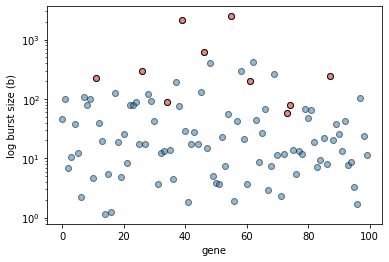

In [19]:
test_out = all_params[0]
test_marks = all_marks[0][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,0],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,0][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log burst size (b)')

[[1.         0.97686407]
 [0.97686407 1.        ]]


Text(0, 0.5, 'param mean U')

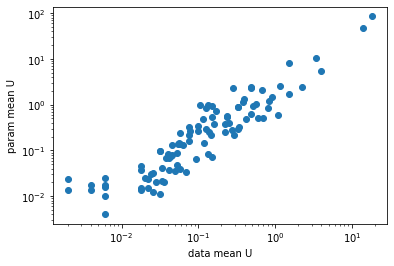

In [20]:
#Check relationship between means and means from params
k1 = all_counts[0][0:500,:,:]
k1.shape

sim_mean = test_out[0,:,0]+test_out[0,:,4]-test_out[0,:,1]
plt.scatter(np.mean(k1[:,:,0],axis=0),10**sim_mean )
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**(sim_mean )))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('data mean U')
plt.ylabel('param mean U')

In [21]:
test_cluster = all_counts[1]

In [22]:
concat_types = np.concatenate((np.mean(test_cluster[0:500,:,:],axis=0),np.mean(test_cluster[500:1000,:,:],axis=0),
          np.mean(test_cluster[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '54'),
 Text(1, 1.5, '12'),
 Text(1, 2.5, '23'),
 Text(1, 3.5, '58'),
 Text(1, 4.5, '39'),
 Text(1, 5.5, '44'),
 Text(1, 6.5, '11'),
 Text(1, 7.5, '65'),
 Text(1, 8.5, '28'),
 Text(1, 9.5, '5'),
 Text(1, 10.5, '73'),
 Text(1, 11.5, '2'),
 Text(1, 12.5, '31'),
 Text(1, 13.5, '6'),
 Text(1, 14.5, '50'),
 Text(1, 15.5, '49'),
 Text(1, 16.5, '51'),
 Text(1, 17.5, '40'),
 Text(1, 18.5, '57'),
 Text(1, 19.5, '62'),
 Text(1, 20.5, '46'),
 Text(1, 21.5, '61'),
 Text(1, 22.5, '45'),
 Text(1, 23.5, '55'),
 Text(1, 24.5, '89'),
 Text(1, 25.5, '83'),
 Text(1, 26.5, '10'),
 Text(1, 27.5, '36'),
 Text(1, 28.5, '42'),
 Text(1, 29.5, '97'),
 Text(1, 30.5, '82'),
 Text(1, 31.5, '29'),
 Text(1, 32.5, '18'),
 Text(1, 33.5, '8'),
 Text(1, 34.5, '63'),
 Text(1, 35.5, '66'),
 Text(1, 36.5, '69'),
 Text(1, 37.5, '17'),
 Text(1, 38.5, '59'),
 Text(1, 39.5, '38'),
 Text(1, 40.5, '48'),
 Text(1, 41.5, '41'),
 Text(1, 42.5, '37'),
 Text(1, 43.5, '3'),
 Text(1, 44.5, '20'),
 Text(1, 45.5, '93'),
 Te

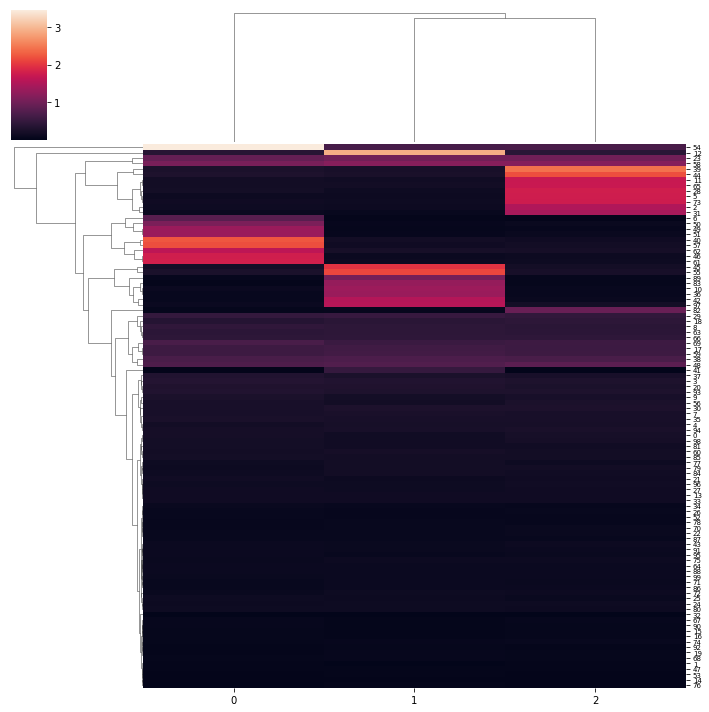

In [23]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[1,3,5]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



Text(0, 0.5, 'Mature counts')

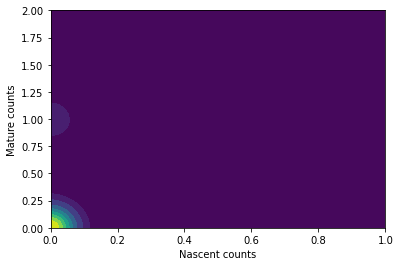

In [24]:
plt.figure()
test_gene = k1[:,50,:]
sns.kdeplot(x=test_gene[:,0], y=test_gene[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test_gene[:,0]),np.max(test_gene[:,0]))
plt.ylim(np.min(test_gene[:,1]),np.max(test_gene[:,1]))
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [25]:
np.max(k1)

183.0

**Save count matrices for Monod**

In [26]:
!mkdir ~/counts/mixMod_sims
!mkdir ~/counts/mixMod_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims’: File exists
mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims/loom/’: File exists


In [27]:
out_names = ['b_sim','b_beta_g_sim','low_b_sim','low_b_beta_g_sim','lowest_b_sim'] 

In [348]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_sims/loom/'
geneNames = names_sub
for ind in range(len(out_names)):
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(n_cells*clus)]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)


Making Loom
/home/tchari/counts/mixMod_sims/loom/b_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/b_beta_g_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/low_b_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/low_b_beta_g_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [349]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[0][0:n_cells,:,0]
S = all_counts[0][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_b_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_b_sim.loom


In [350]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta and gamma sim -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[1][0:n_cells,:,0]
S = all_counts[1][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_b_beta_g_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_b_beta_g_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [351]:
# #Check loom ok
# ds = lp.connect('/home/tchari/counts/mixMod_sims/loom/b_sim.loom')

In [352]:
# ds

In [353]:
# ds.close()

## **Run Inference**

In [28]:
rep_data = list(np.repeat(out_names,5))+['oneClus_b_sim']+['oneClus_b_beta_g_sim']
ks = [1,2,3,4,5]*len(out_names)+[1,1]

dataset_meta = rep_data #['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()


cluster_names = []

d_names = []
for i in range(len(ks)):
    d_names += [rep_data[i]+'_k'+str(ks[i])]
    
dataset_names = d_names  #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = rep_data 
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3' #'gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['b_sim', 'b_sim', 'b_sim', 'b_sim', 'b_sim', 'b_beta_g_sim', 'b_beta_g_sim', 'b_beta_g_sim', 'b_beta_g_sim', 'b_beta_g_sim', 'low_b_sim', 'low_b_sim', 'low_b_sim', 'low_b_sim', 'low_b_sim', 'low_b_beta_g_sim', 'low_b_beta_g_sim', 'low_b_beta_g_sim', 'low_b_beta_g_sim', 'low_b_beta_g_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'oneClus_b_sim', 'oneClus_b_beta_g_sim']

dataset_names:  ['b_sim_k1', 'b_sim_k2', 'b_sim_k3', 'b_sim_k4', 'b_sim_k5', 'b_beta_g_sim_k1', 'b_beta_g_sim_k2', 'b_beta_g_sim_k3', 'b_beta_g_sim_k4', 'b_beta_g_sim_k5', 'low_b_sim_k1', 'low_b_sim_k2', 'low_b_sim_k3', 'low_b_sim_k4', 'low_b_sim_k5', 'low_b_beta_g_sim_k1', 'low_b_beta_g_sim_k2', 'low_b_beta_g_sim_k3', 'low_b_beta_g_sim_k4', 'low_b_beta_g_sim_k5', 'lowest_b_sim_k1', 'lowest_b_sim_k2', 'lowest_b_sim_k3', 'lowest_b_sim_k4', 'lowest_b_sim_k5', 'oneClus_b_sim_k1', 'oneClus_b_beta_g_sim_k1']
len(dataset_names):  27

loom_filepaths:  ['/home/tchari/counts

In [29]:
print(n_datasets)

27


Dataset b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset b_sim. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset b_beta_g_sim. 
	1500 barcod

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


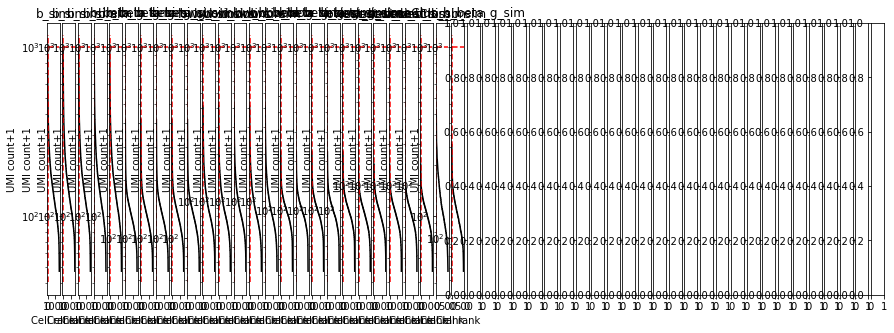

In [30]:
#Not filtering cells for now
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        #for subcluster in subcluster_names:
        subcluster = 'Keep All'
        annot_bcs = bcs
        #cf.append(np.isin(bcs,annot_bcs) & cf_)
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [31]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [32]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


(array([ 8.,  9., 15., 23., 15., 10.,  9.,  4.,  5.,  2.]),
 array([0.15651831, 0.4456771 , 0.73483588, 1.02399467, 1.31315345,
        1.60231223, 1.89147102, 2.1806298 , 2.46978859, 2.75894737,
        3.04810615]),
 <BarContainer object of 10 artists>)

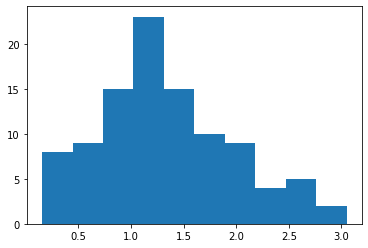

In [33]:
plt.hist((params[0,:,0]))

In [34]:
# k=3
# epochs=10

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1 already exists.
INFO:root:Dataset: b_sim_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:52 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k1 already exists.
INFO:root:Dataset: b_sim_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:52 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k2 already exists.
INFO:root:Dataset: b_sim_k3
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:52 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k3 already exists.
INFO:root:Dataset: b_sim_k4
INFO:root:1500 cells detected.


/home/tchari/monod/src/monod/preprocess.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:30 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1 already exists.
INFO:root:Dataset: oneClus_b_beta_g_sim_k1
INFO:root:500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:27 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1 already exists.
INFO:root:Total of 100 genes selected.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/diagnostic_figures already exists.


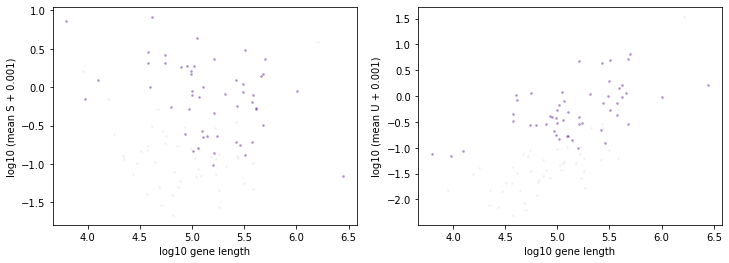

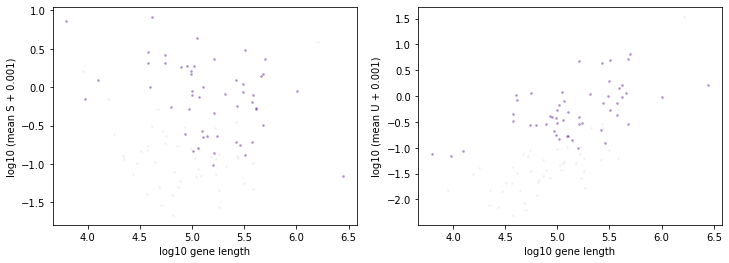

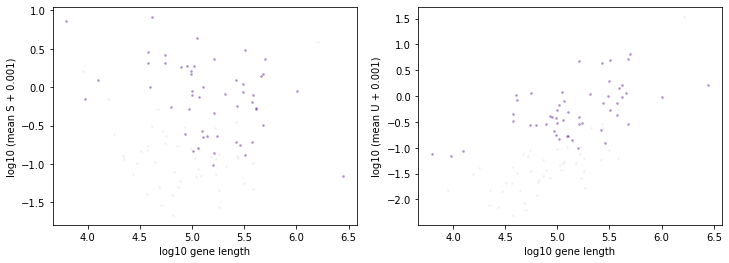

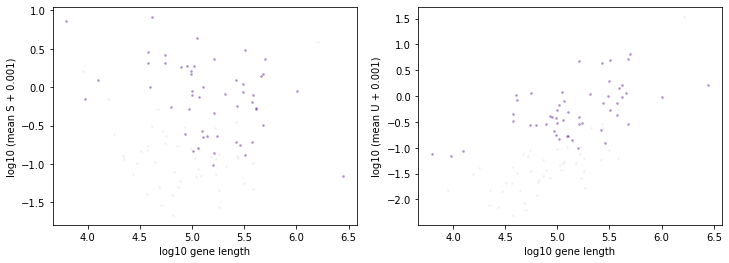

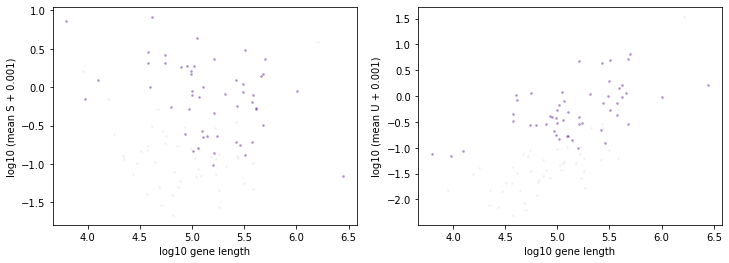

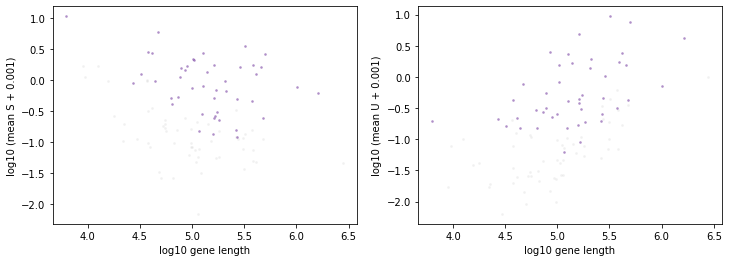

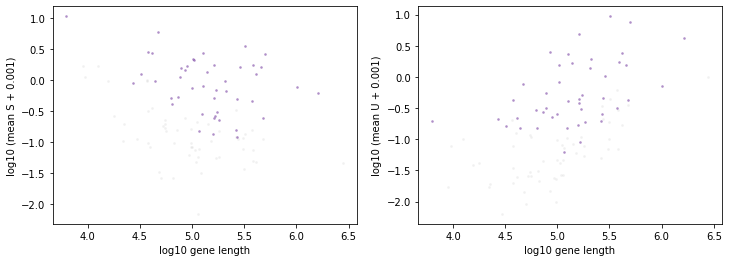

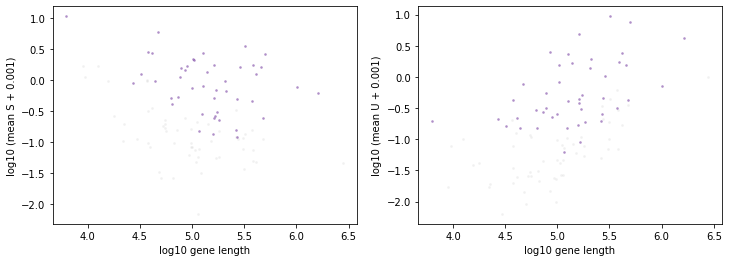

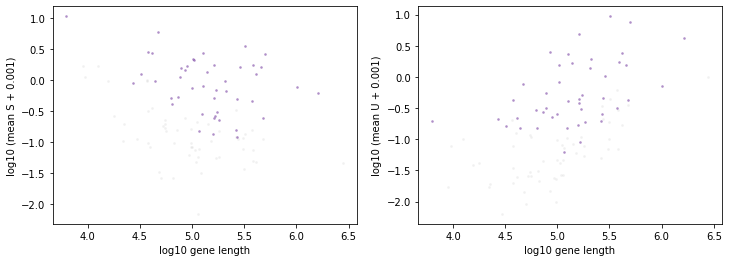

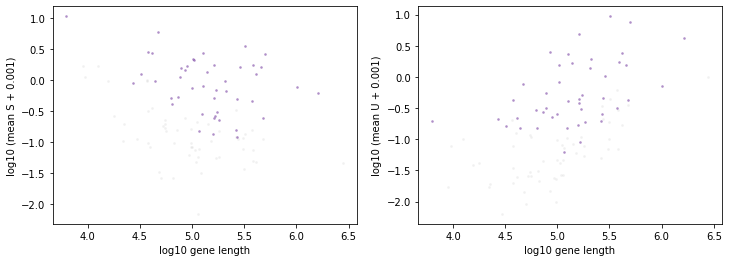

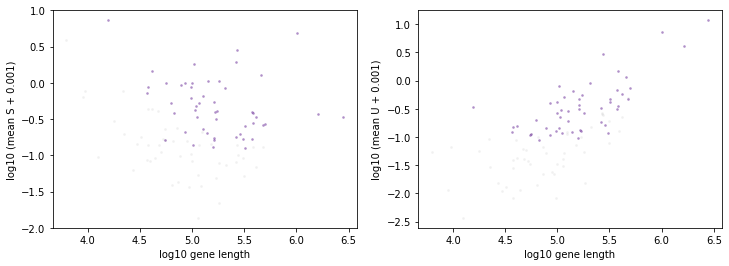

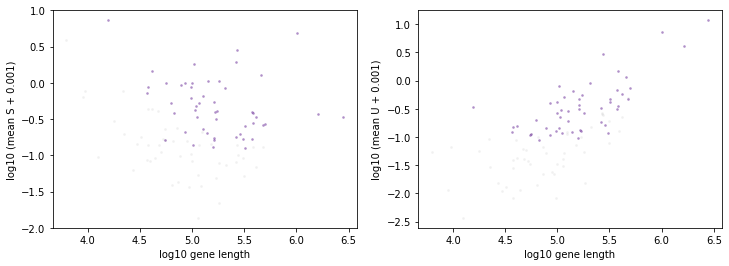

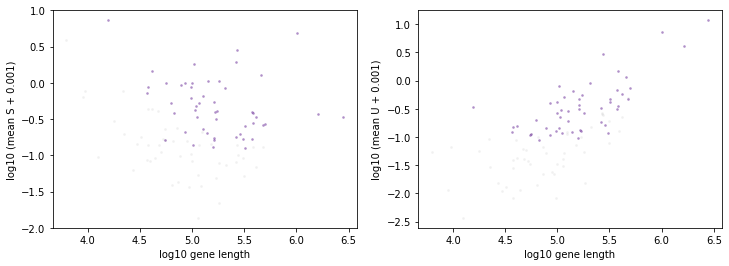

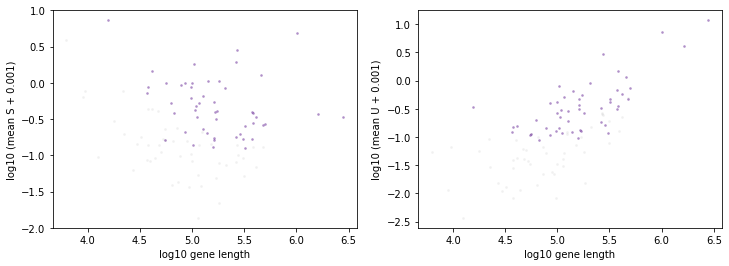

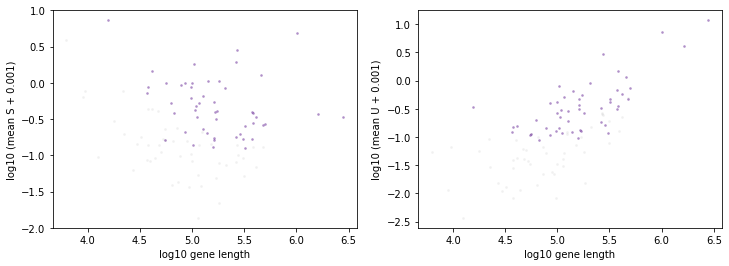

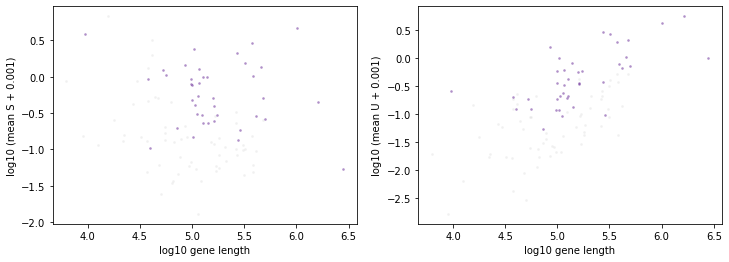

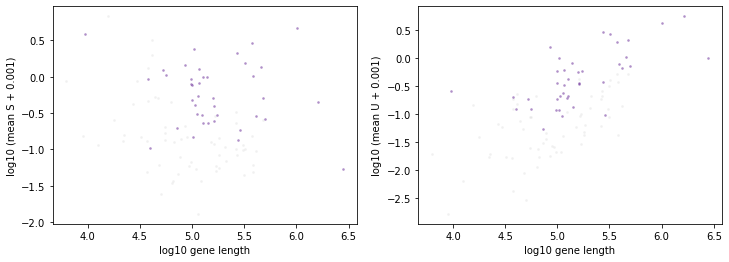

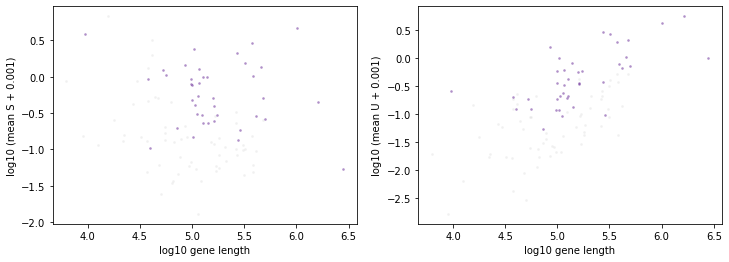

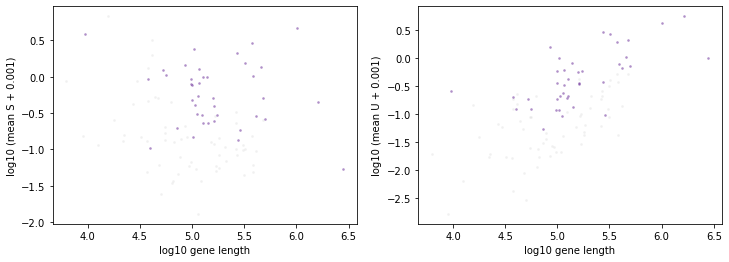

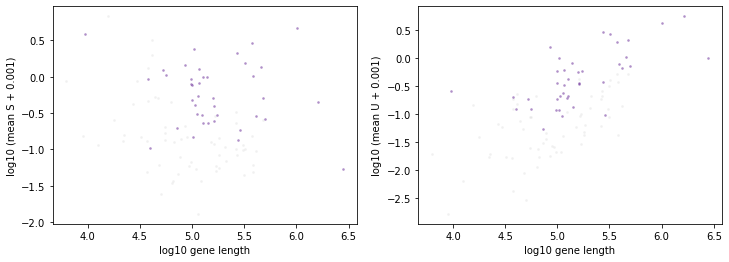

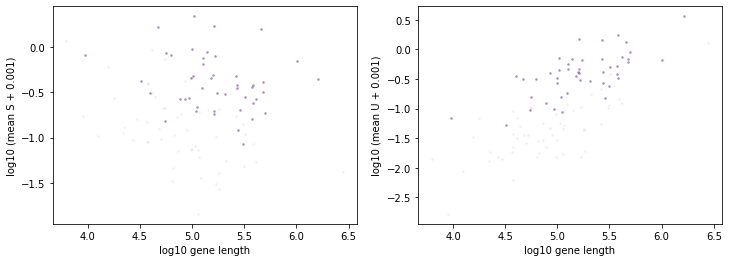

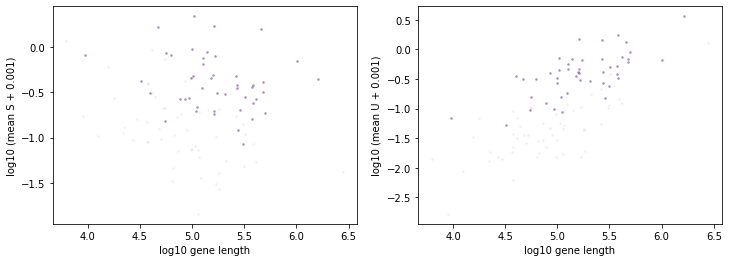

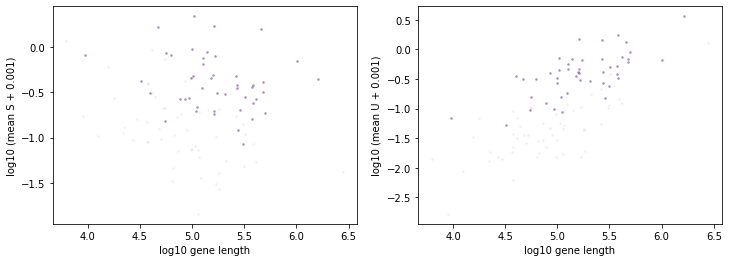

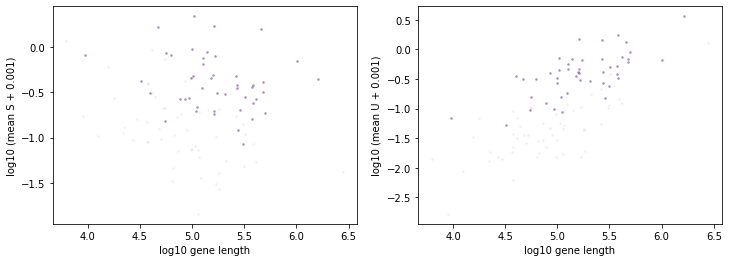

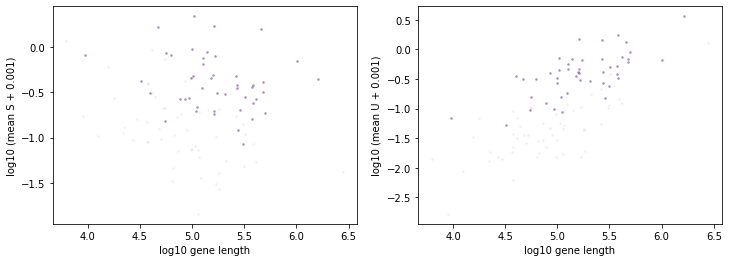

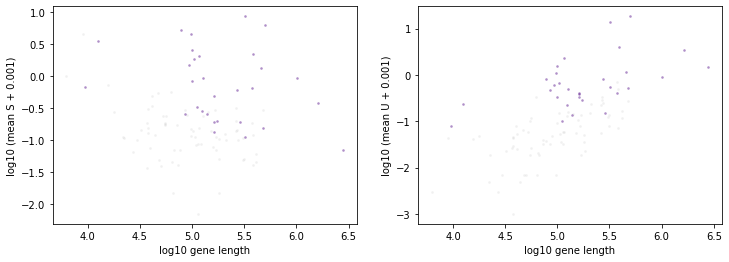

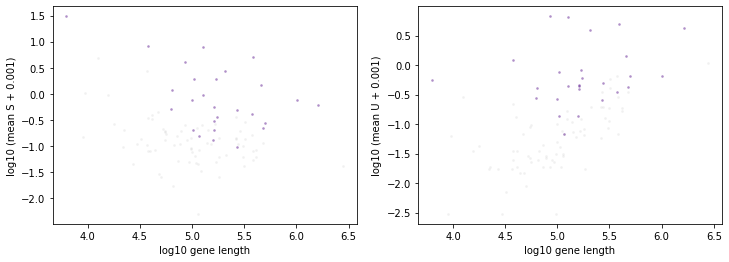

In [35]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='simTests_MM',batch_id=1,\
                                             datestring='230404', n_genes=100,exp_filter_threshold=None,cf=cf)

**Control test with standard Monod fit on first, known cluster of cells**

INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 3.3 seconds.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 3.1 seconds.


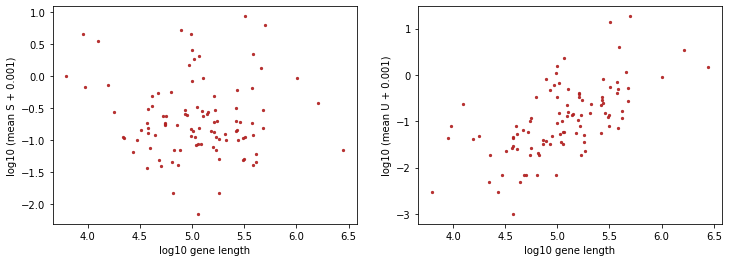

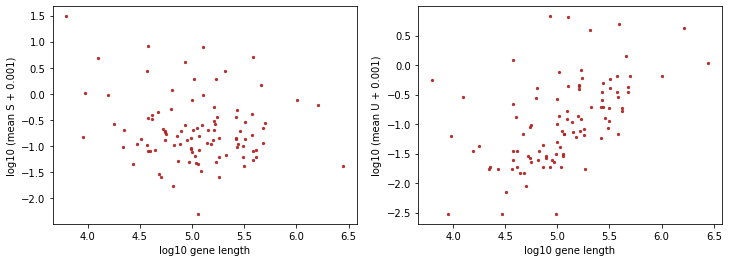

In [36]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(ks)-2,len(ks)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [37]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230404_025_simTests_MM_1/oneClus_b_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230404_025_simTests_MM_1/oneClus_b_beta_g_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.


**Run Mixture Model on all cells**

In [38]:
epochs=10

INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -140.17302940840082

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k2/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.38s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33336073 0.66663927]
logL:  -136.4810710958476

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.44326464190937

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337671 0.66662329]
logL:  -136.443264641335

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.07s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.4097099862157

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333504 0.33333335 0.33333161]
logL:  -132.40970998620685

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k4/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333331 0.33333335 0.28678712 0.04654622]
logL:  -133.21620670162335

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33268844 0.33333335 0.3238387  0.01013951]
logL:  -132.47138522082844

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33322947e-01 3.33333348e-01 3.33334349e-01 9.35676869e-06]
logL:  -132.42212449223655

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331600e-01 3.33333349e-01 3.33335043e-01 7.72971364e-09]
logL:  -132.4097193360257

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331607e-01 3.33333349e-01 3.33335043e-01 6.72501424e-10]
logL:  -132.40970999393068

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331607e-01 3.33333349e-01 3.33335043e-01 6.67174301e-10]
logL:  -132.40970998687882

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331607e-01 3.33333349e-01 3.33335043e-01 6.67170280e-10]
logL:  -132.4097099868735

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331607e-01 3.33333349e-01 3.33335043e-01 6.67170277e-10]
logL:  -132.4097099868735

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331607e-01 3.33333349e-01 3.33335043e-01 6.67170277e-10]
logL:  -132.4097099868735

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33331607e-01 3.33333349e-01 3.33335043e-01 6.67170277e-10]
logL:  -132.4097099868735

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_sim_k5/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333335 0.04571939 0.24518458 0.28761395 0.08814874]
logL:  -133.33882384652048

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333401 0.01009884 0.25543337 0.32394107 0.07719271]
logL:  -132.82128154530182

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333339e-01 9.40930701e-05 3.33069205e-01 3.33333538e-01
 1.69825135e-04]
logL:  -131.74323659505046

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333349e-01 3.27117754e-07 3.28149386e-01 3.33335044e-01
 5.18189401e-03]
logL:  -132.38484739626517

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333335e-01 2.47722113e-09 3.30520943e-01 3.33333426e-01
 2.81229393e-03]
logL:  -131.52078150616614

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333346e-01 6.73643657e-10 3.33238141e-01 3.33334694e-01
 9.38190034e-05]
logL:  -132.41541674738662

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333349e-01 6.69003796e-10 3.33329264e-01 3.33335043e-01
 2.34325001e-06]
logL:  -132.40980147227953

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333349e-01 6.68987064e-10 3.33331548e-01 3.33335043e-01
 5.93607875e-08]
logL:  -132.40971227143507

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333349e-01 6.68986990e-10 3.33331606e-01 3.33335043e-01
 2.15366307e-09]
logL:  -132.4097100447473

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333349e-01 6.68986990e-10 3.33331607e-01 3.33335043e-01
 7.20616346e-10]
logL:  -132.40970998897322

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k1/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -134.18626289394692

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_beta_g_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k2/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66808618 0.33191382]
logL:  -148.69635621365015

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68093244 0.31906756]
logL:  -147.05510715185852

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.70711205 0.29288795]
logL:  -145.9396664759846

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.9491663 0.0508337]
logL:  -139.79012349374779

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 7.25885312e-10]
logL:  -134.28923405717336

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
logL:  -134.1862628946728

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
logL:  -134.18626289461358

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
logL:  -134.18626289461358

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
logL:  -134.18626289461358

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
logL:  -134.18626289461358

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.8963463705577

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333343 0.33333333 0.33333324]
logL:  -147.89634637055772

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_beta_g_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k4/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.32934194 0.33330661 0.00401812]
logL:  -151.19534647404637

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33331064e-01 3.33335602e-01 6.66666665e-10]
logL:  -148.81008505716235

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.8963463712411

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333427e-01 3.33333240e-01 6.66666665e-10]
logL:  -147.89634637122435

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: b_beta_g_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k5/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/b_beta_g_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0039914  0.33333333 0.02449685 0.30883648 0.32934193]
logL:  -143.5200084745228

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 2.26239230e-01 1.07095625e-01
 3.33331811e-01]
logL:  -145.21433357384754

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.79244491e-10 3.33333333e-01
 3.33333333e-01]
logL:  -135.47465024016566

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.75016841e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.89634637189528

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.74964871e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.8963463718911

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.74964232e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.89634637189104

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.74964224e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.89634637189104

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.74964224e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.89634637189104

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.74964224e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.89634637189104

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.33333333e-01 6.74964224e-10 3.33333239e-01
 3.33333426e-01]
logL:  -147.89634637189104

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k1/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -120.70477676064476

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k2/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33172489 0.66827511]
logL:  -119.00597514291387

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33262018 0.66737982]
logL:  -118.1876173201589

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33163027 0.66836973]
logL:  -118.9768624648727

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162725 0.66837275]
logL:  -118.97686024985207

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162724 0.66837276]
logL:  -118.97686024983143

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162724 0.66837276]
logL:  -118.97686024983143

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162724 0.66837276]
logL:  -118.97686024983143

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162724 0.66837276]
logL:  -118.97686024983143

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162724 0.66837276]
logL:  -118.97686024983143

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33162724 0.66837276]
logL:  -118.97686024983143

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33234441 0.33286638 0.33478921]
logL:  -116.53609234649907

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33227939 0.33256456 0.33515605]
logL:  -116.40754293120784

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33223852 0.33267697 0.33508451]
logL:  -116.3965056357699

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33213709 0.33335811 0.3345048 ]
logL:  -117.08921689371101

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33236601 0.33335996 0.33427403]
logL:  -117.10696011730619

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33227976 0.3325651  0.33515513]
logL:  -116.4075447095435

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33223852 0.33267697 0.33508451]
logL:  -116.39650563543901

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33213709 0.33335811 0.3345048 ]
logL:  -117.08921689370962

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33236601 0.33335996 0.33427403]
logL:  -117.10696011730619

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33227976 0.3325651  0.33515513]
logL:  -116.4075447095435

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k4/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24958134 0.33331215 0.09609472 0.32101179]
logL:  -115.70883273288798

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23340875 0.3322856  0.12033639 0.31396926]
logL:  -115.97340100773303

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30025706 0.33245382 0.05282612 0.31446301]
logL:  -115.60944486043645

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32009455 0.33265417 0.03274424 0.31450704]
logL:  -116.18792945682885

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32925522 0.33302631 0.03120625 0.30651222]
logL:  -116.82283643715277

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33325759 0.33331666 0.00795664 0.32546911]
logL:  -115.5425726109142

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33338531 0.33335887 0.0065644  0.32669142]
logL:  -116.99668105234979

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33401616 0.33335886 0.00389431 0.32873067]
logL:  -117.08861314704261

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33486922 0.33256375 0.00399998 0.32856705]
logL:  -115.61896949489349

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3347744  0.3326766  0.00399998 0.32854902]
logL:  -115.60802081309446

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k5/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09838248 0.24584359 0.15077452 0.18252434 0.32247507]
logL:  -116.21854759607209

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.13220596 0.2262103  0.06970889 0.2636187  0.30825615]
logL:  -116.18502335687741

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.071273   0.26955202 0.02718522 0.30573209 0.32625766]
logL:  -114.99411121900252

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.05418396 0.3023594  0.02028134 0.31310078 0.31007452]
logL:  -116.84049361544723

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0175368  0.32722019 0.00357808 0.33054687 0.32111806]
logL:  -114.7633239932141

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.23504571e-03 3.33220227e-01 6.66694051e-10 3.33460955e-01
 3.26083772e-01]
logL:  -116.98799739619406

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.68463334e-03 3.34024733e-01 6.66666664e-10 3.33358876e-01
 3.28931757e-01]
logL:  -117.09332220648632

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.01332897e-03 3.34761211e-01 6.66666664e-10 3.32564163e-01
 3.30661296e-01]
logL:  -114.9135653710607

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.28149505e-09 3.35086211e-01 6.66666664e-10 3.32676993e-01
 3.32236789e-01]
logL:  -116.39784545218568

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66678721e-10 3.34504802e-01 6.66666664e-10 3.33358111e-01
 3.32137085e-01]
logL:  -117.08921690303306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -124.38419775236905

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_beta_g_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k2/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33299705 0.66700295]
logL:  -119.98449608600718

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33269534 0.66730466]
logL:  -119.96225859128101

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326953 0.6673047]
logL:  -119.96225838631399

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459269 0.33333323 0.33207408]
logL:  -125.24414611576302

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333344 0.33333322 0.33333334]
logL:  -125.57396805166796

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459269 0.33333323 0.33207408]
logL:  -125.24414611540226

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333344 0.33333322 0.33333334]
logL:  -125.57396805166822

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459269 0.33333323 0.33207408]
logL:  -125.24414611540226

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333344 0.33333322 0.33333334]
logL:  -125.57396805166822

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459269 0.33333323 0.33207408]
logL:  -125.24414611540226

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333344 0.33333322 0.33333334]
logL:  -125.57396805166822

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459269 0.33333323 0.33207408]
logL:  -125.24414611540226

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333344 0.33333322 0.33333334]
logL:  -125.57396805166822

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_beta_g_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k4/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459259 0.25837633 0.33207408 0.074957  ]
logL:  -124.82386683732

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333331 0.24618866 0.33333333 0.0871447 ]
logL:  -124.40864573216635

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33459258 0.25817719 0.33207408 0.07515615]
logL:  -124.1464699140405

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333306 0.31076984 0.33333334 0.02256376]
logL:  -124.6414403340635

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34606342e-01 3.33319495e-01 3.32074163e-01 6.73060863e-10]
logL:  -124.80445492909377

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333436e-01 3.33333223e-01 3.33333340e-01 6.66666665e-10]
logL:  -125.5739681039881

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34592685e-01 3.33333233e-01 3.32074081e-01 6.66666665e-10]
logL:  -125.24414611606889

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333436e-01 3.33333223e-01 3.33333340e-01 6.66666665e-10]
logL:  -125.57396805233489

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34592685e-01 3.33333233e-01 3.32074081e-01 6.66666665e-10]
logL:  -125.24414611606893

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333436e-01 3.33333223e-01 3.33333340e-01 6.66666665e-10]
logL:  -125.57396805233488

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: low_b_beta_g_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k5/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/low_b_beta_g_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized M

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.074957   0.33267697 0.25837633 0.00065637]
logL:  -116.15194180360567

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34551431e-01 8.71447076e-02 3.32115199e-01 2.46188661e-01
 6.66666664e-10]
logL:  -123.95861351638078

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333323e-01 7.51561490e-02 3.33333338e-01 2.58177190e-01
 6.66666664e-10]
logL:  -124.47629155901181

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34592114e-01 2.25639688e-02 3.32074079e-01 3.10769838e-01
 6.66666664e-10]
logL:  -124.3116181799887

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33348667e-01 6.73060921e-10 3.33333420e-01 3.33317911e-01
 6.66666664e-10]
logL:  -125.13427546335109

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34592690e-01 6.66666665e-10 3.32074076e-01 3.33333233e-01
 6.66666664e-10]
logL:  -125.24414606020588

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333435e-01 6.66666665e-10 3.33333340e-01 3.33333223e-01
 6.66666664e-10]
logL:  -125.57396805303955

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34592685e-01 6.66666665e-10 3.32074081e-01 3.33333233e-01
 6.66666664e-10]
logL:  -125.2441461167356

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333435e-01 6.66666665e-10 3.33333340e-01 3.33333223e-01
 6.66666664e-10]
logL:  -125.57396805300156

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34592685e-01 6.66666665e-10 3.32074081e-01 3.33333233e-01
 6.66666664e-10]
logL:  -125.24414611673559

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k1


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


/home/tchari/monod/src/monod/extract_data.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
logL:  -113.59054674558021

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k2/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31942549 0.68057451]
logL:  -112.00788473536184

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30487241 0.69512759]
logL:  -109.74921081170122

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34415718 0.65584282]
logL:  -110.70783144074069

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33303859 0.66696141]
logL:  -111.4791421513607

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32933631 0.67066369]
logL:  -110.94165297371619

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32760323 0.67239677]
logL:  -110.69502717543081

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31482257 0.68517743]
logL:  -109.38162271242818

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35477151 0.64522849]
logL:  -110.26333538419637

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33243812 0.66756188]
logL:  -111.59059401186516

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32200313 0.67799687]
logL:  -111.00199066087235

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3239638  0.40782455 0.26821165]
logL:  -111.02439609970979

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.19638241 0.47736617 0.32625142]
logL:  -108.95998223791912

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.31159293 0.37667828 0.31172879]
logL:  -110.67455045608541

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29198988 0.37995472 0.3280554 ]
logL:  -108.11084316678404

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34700984 0.33518431 0.31780586]
logL:  -109.5607714404869

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3158561  0.34402221 0.34012169]
logL:  -107.91544176851446

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30436236 0.37088939 0.32474826]
logL:  -109.70684917328433

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3263452  0.33527631 0.33837849]
logL:  -109.15725028052313

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31540408 0.35978242 0.3248135 ]
logL:  -108.82057036729728

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31234682 0.33138467 0.35626851]
logL:  -110.18454587575968

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k4/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30335216 0.24700561 0.24184426 0.20779797]
logL:  -109.64994692137896

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32561202 0.06054383 0.31447031 0.29937384]
logL:  -107.3777731428511

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35193855 0.0435389  0.31635758 0.28816496]
logL:  -109.65634395374765

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34166261 0.02310592 0.32872982 0.30650166]
logL:  -108.82040301026551

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33565923 0.00131931 0.31891753 0.34410393]
logL:  -107.87057976570435

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.28087790e-01 6.66666665e-10 3.59865214e-01 3.12046995e-01]
logL:  -109.31847994752624

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.62259546e-01 6.66666665e-10 3.32675685e-01 3.05064768e-01]
logL:  -109.57445419590262

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.26981340e-01 6.66666665e-10 3.60186750e-01 3.12831909e-01]
logL:  -108.97128098319881

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.58840186e-01 6.66666665e-10 3.33069329e-01 3.08090484e-01]
logL:  -109.83526542091408

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.27530927e-01 6.66666665e-10 3.59703151e-01 3.12765922e-01]
logL:  -108.86499204892996

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230404_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k5/diagnostic_figures already exists.


INFO:root:Search data stored to ./fits/gg_230404_025_simTests_MM_1/lowest_b_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24969775 0.29493173 0.11583717 0.1303657  0.20916765]
logL:  -110.30232048860972

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.10470939 0.32555489 0.13069128 0.1859636  0.25308083]
logL:  -107.60274656078225

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.11830235 0.33738712 0.10507879 0.21988839 0.21934334]
logL:  -109.86313181297277

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.05136171 0.33269754 0.11576441 0.21430597 0.28587036]
logL:  -107.64742346021414

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09669228 0.35490672 0.17380836 0.16013698 0.21445567]
logL:  -109.08235875594558

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01114606 0.37590592 0.04990484 0.28973176 0.27331141]
logL:  -109.11767438700636

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.84614054e-10 3.59795467e-01 9.68718597e-02 2.41382514e-01
 3.01950159e-01]
logL:  -110.42490266068533

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.57981074e-01 5.32506599e-02 2.87030660e-01
 3.01737606e-01]
logL:  -107.80216084124703

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.52792653e-01 2.18544294e-03 3.26340034e-01
 3.18681869e-01]
logL:  -110.76429529652943

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.48285134e-01 6.66666664e-10 3.44517772e-01
 3.07197094e-01]
logL:  -107.97040173614072

INFO:root:Non-parallelized grid scan complete.


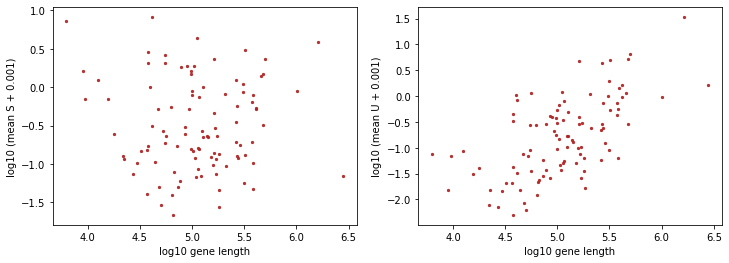

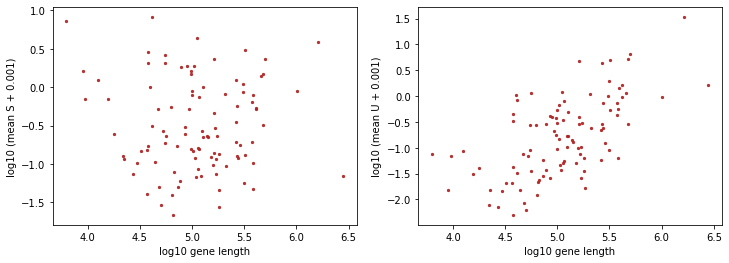

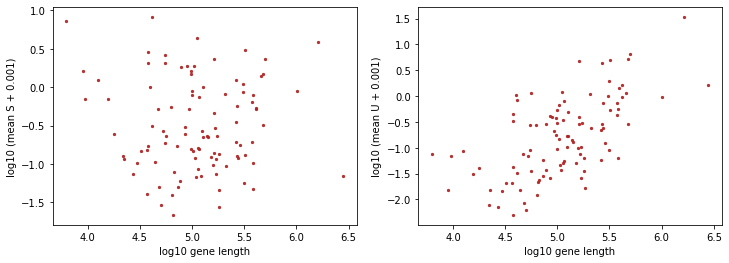

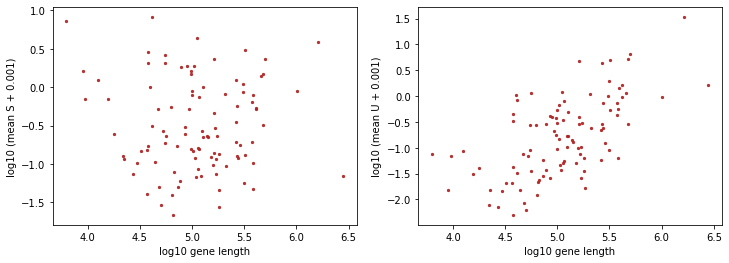

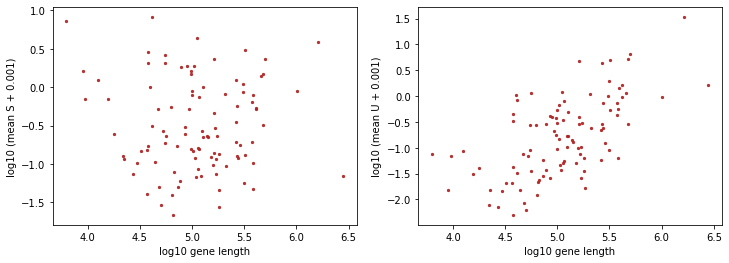

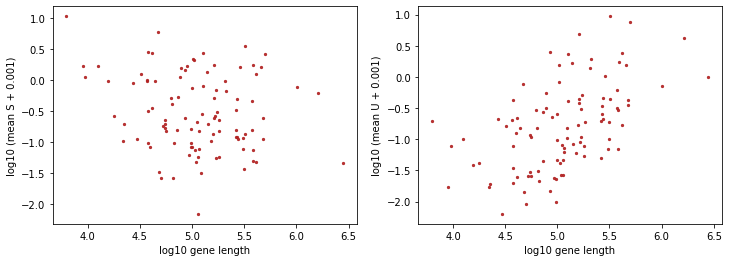

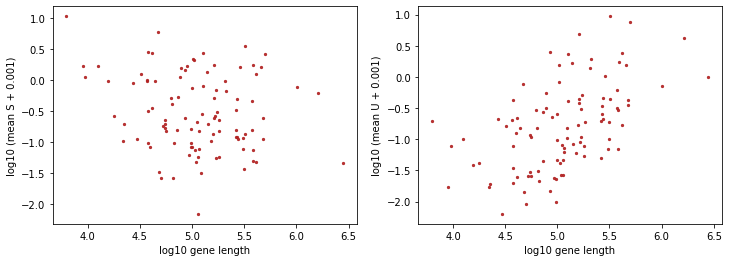

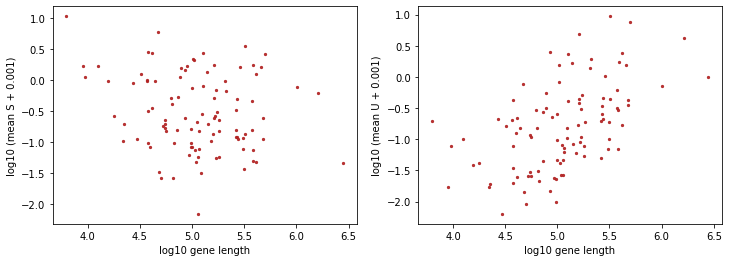

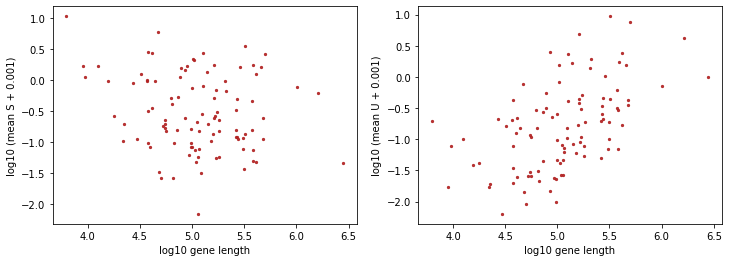

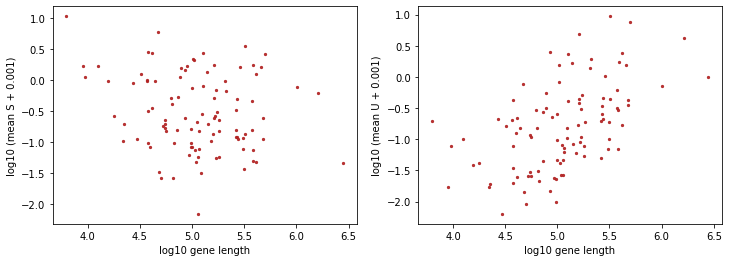

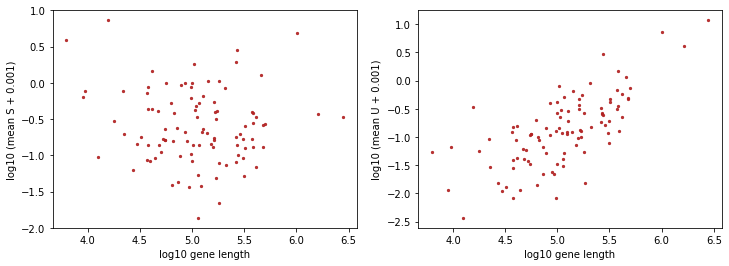

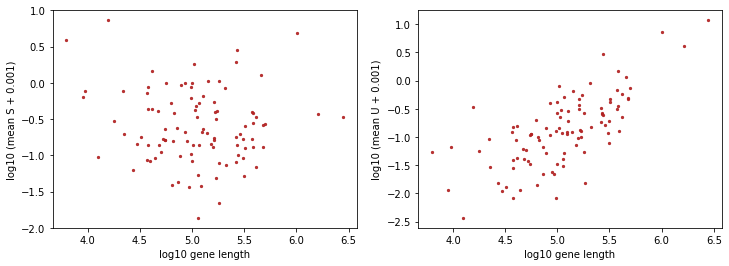

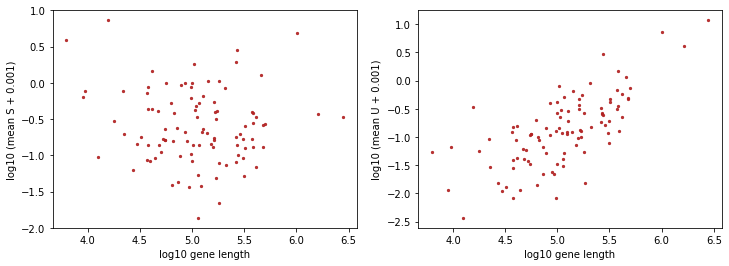

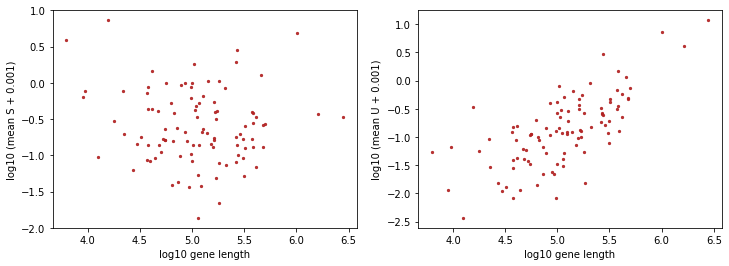

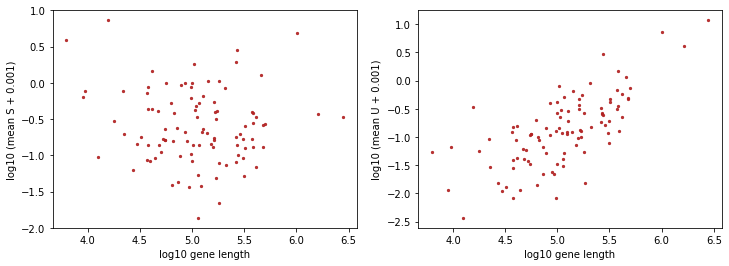

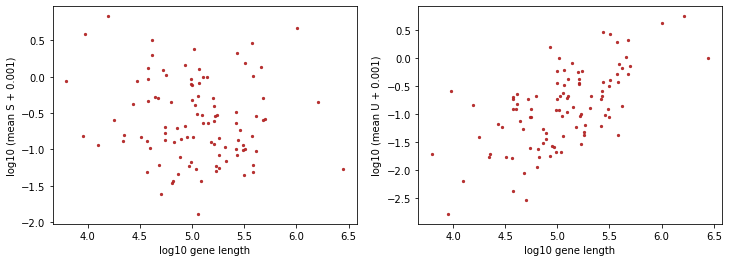

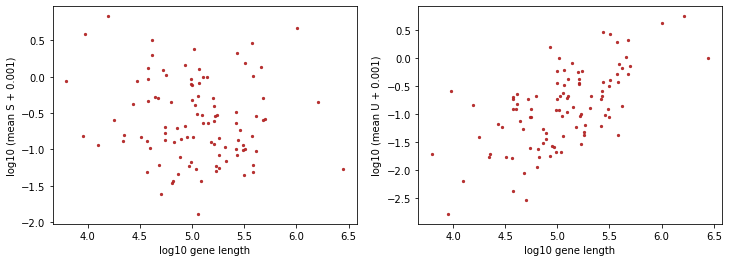

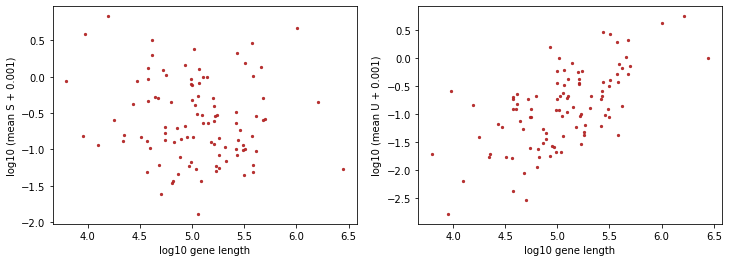

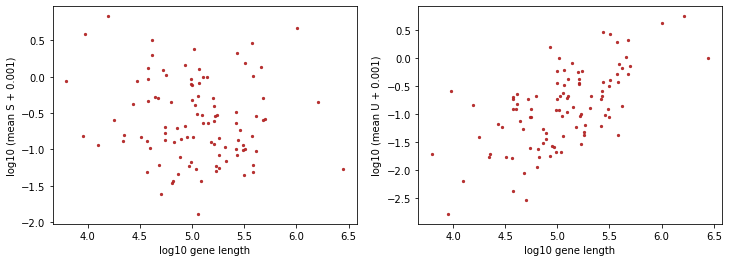

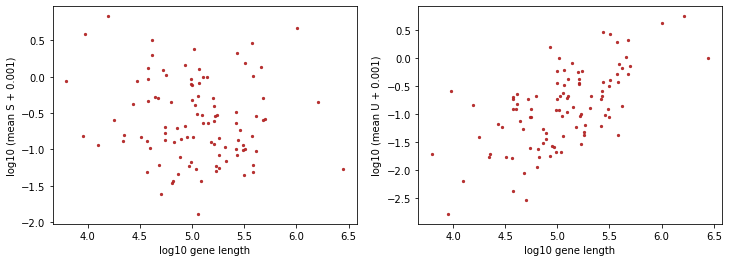

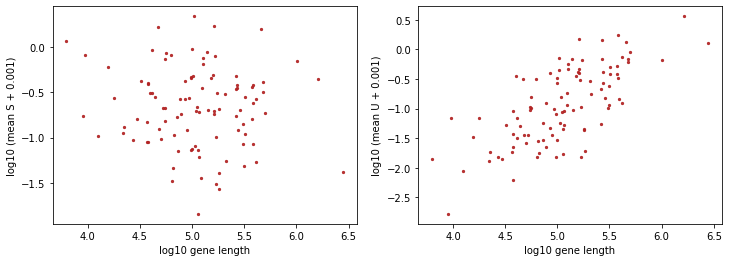

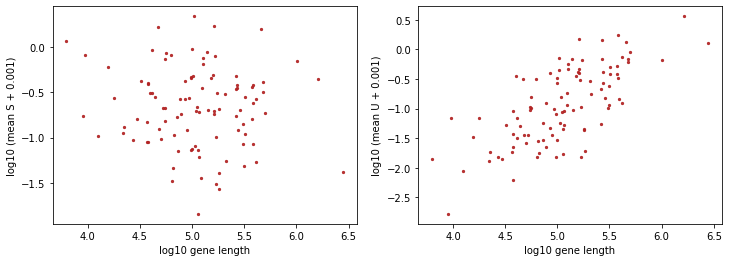

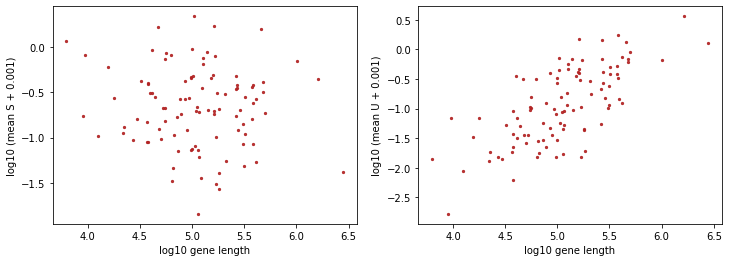

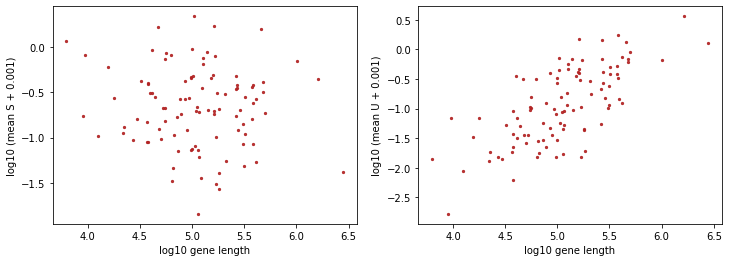

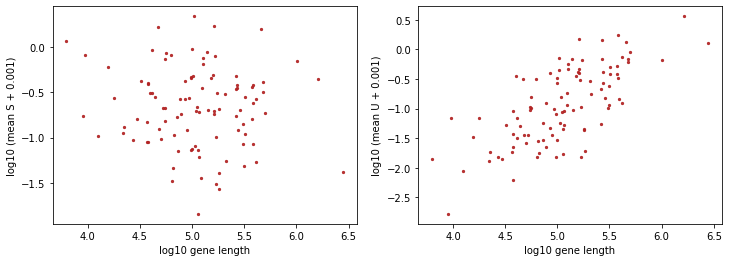

In [39]:

result_strings = []
for i in range(len(ks)-2): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


In [42]:
# S = search_data.layers[1,:,:]
# corrs = np.corrcoef(S.T)-np.eye(S.shape[1]) #cellxcell (COV)
# out = np.linalg.eigh(corrs)
# vs =  out[1]

## **Analysis of Results**

In [40]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1')
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [51]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_bounds)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_bounds))
        sets += [i+1]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        
    
    
    
    res['NLL'] = nlls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in np.array(range(num_ks))+1 ]
    aics['fin_k'] = fin_k
    
    klds['KLD'] = kls
    klds['k'] = [str(j) for j in np.array(range(num_ks))+1 ]
    klds['fin_k'] = fin_k
    
    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Final k')
    ax[1].set_ylabel('-AIC')
    ax[1].legend(
          title='k')
    
    
    #Plot klds
    sns.scatterplot(data=klds,x='fin_k',y='KLD',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('KLD')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [42]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[:-2]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


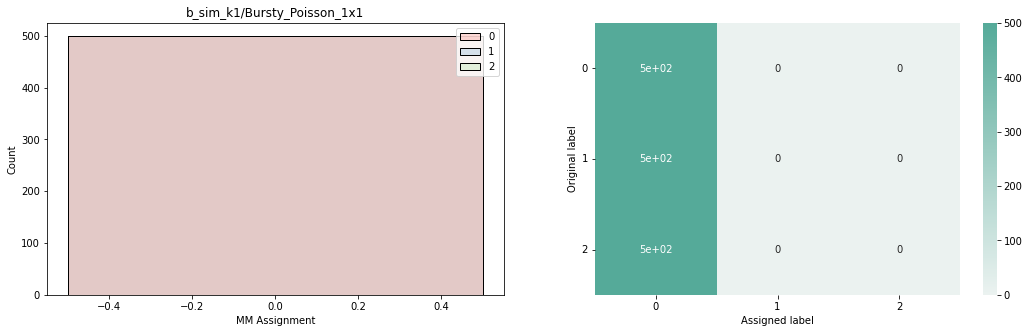

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


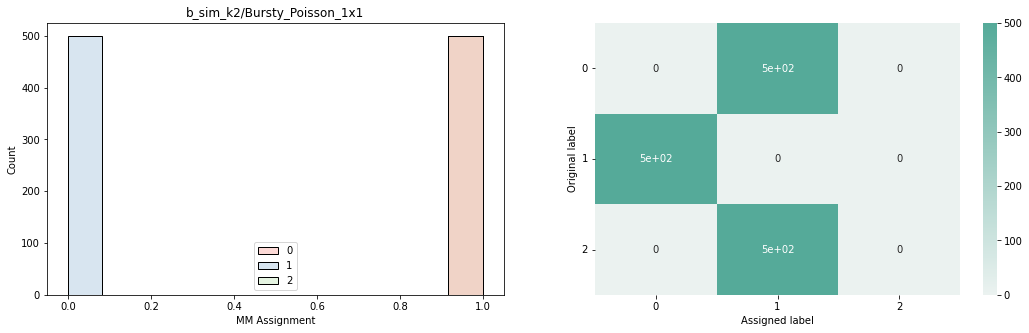

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


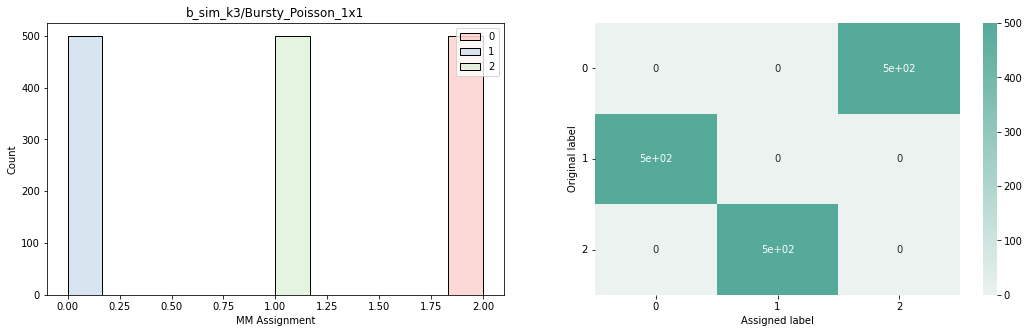

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


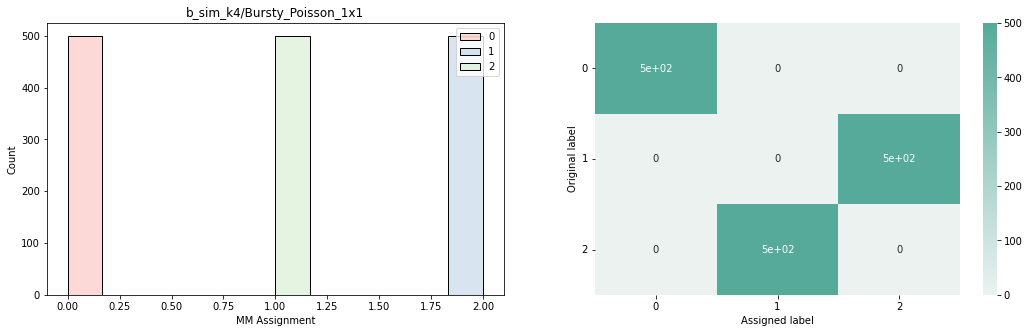

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


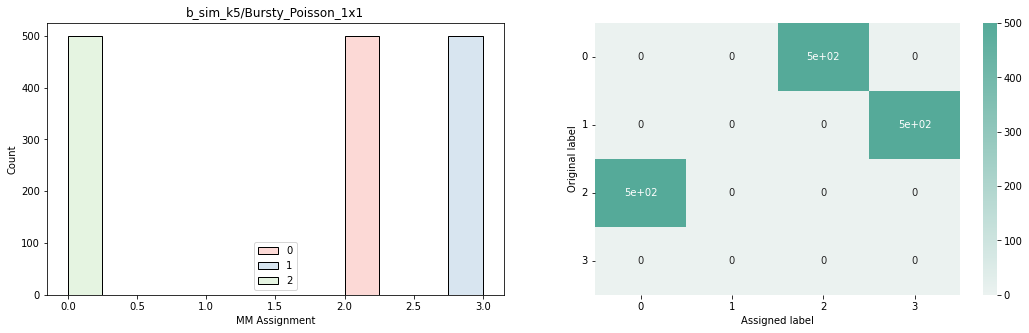

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


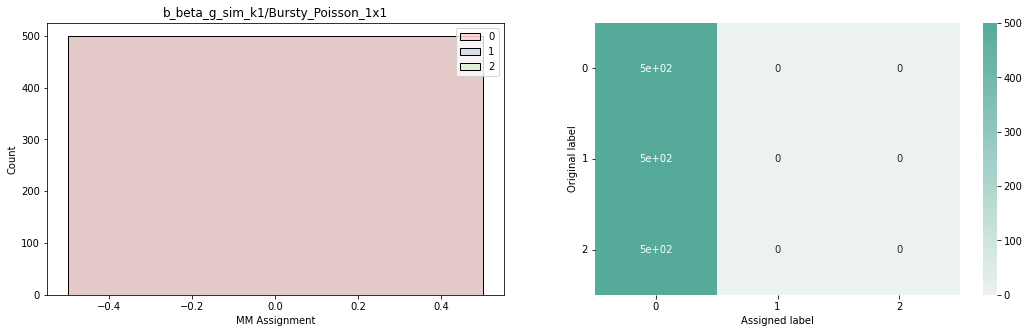

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


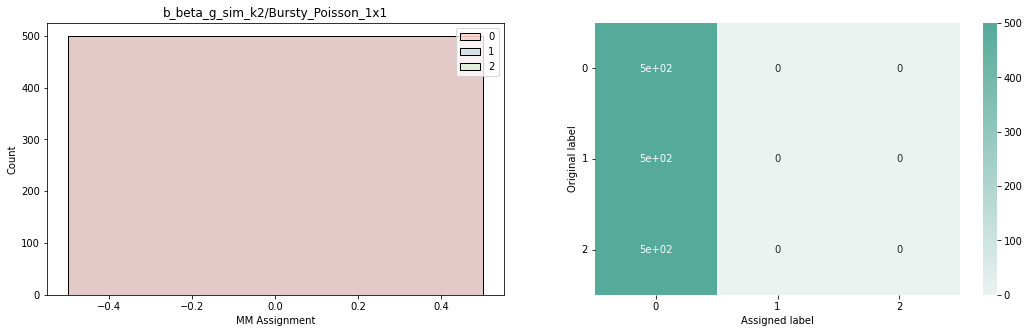

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


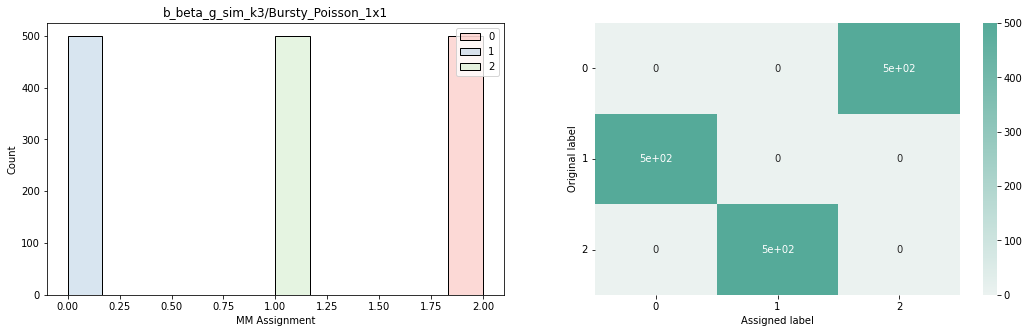

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


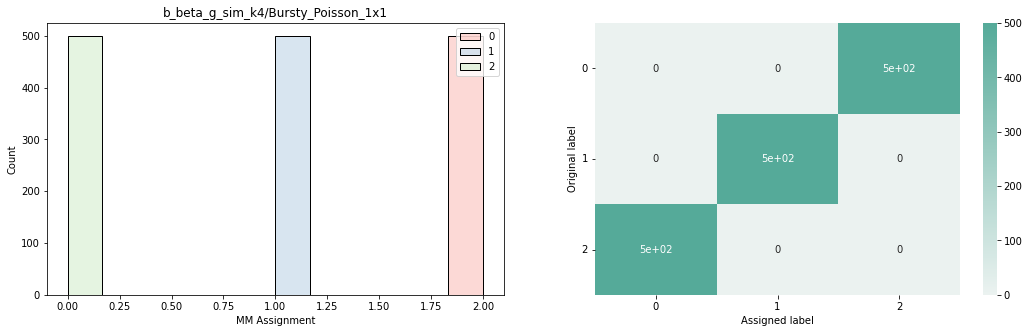

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


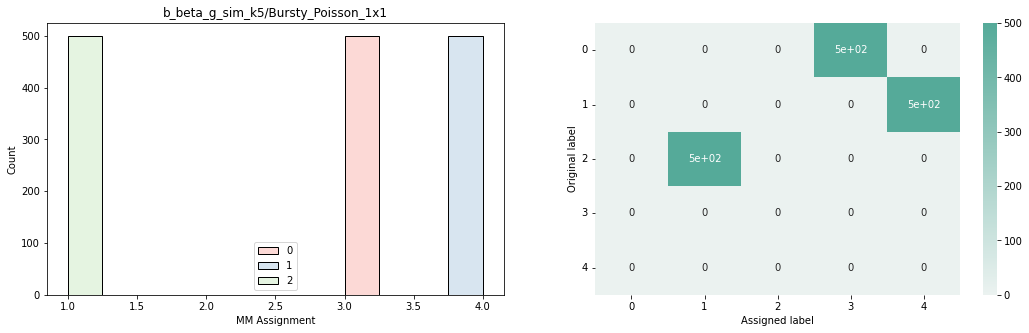

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


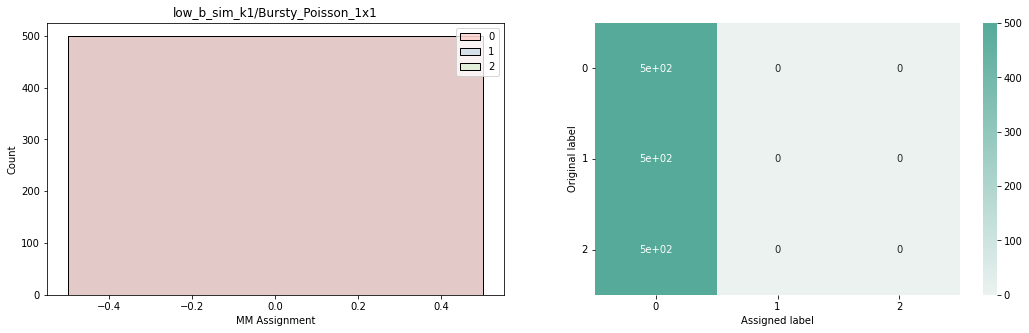

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


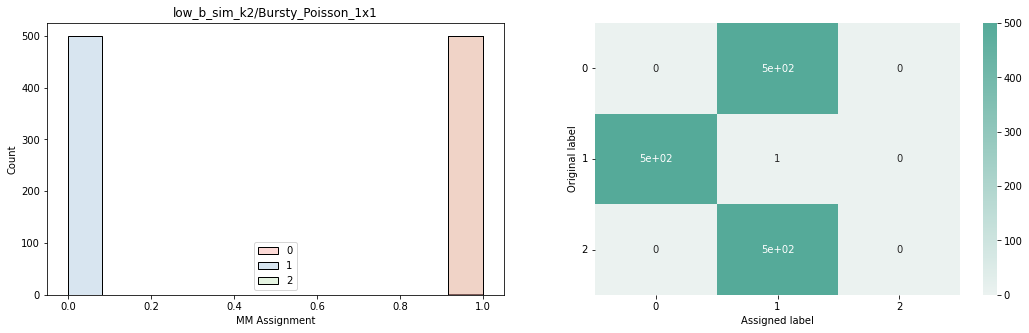

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


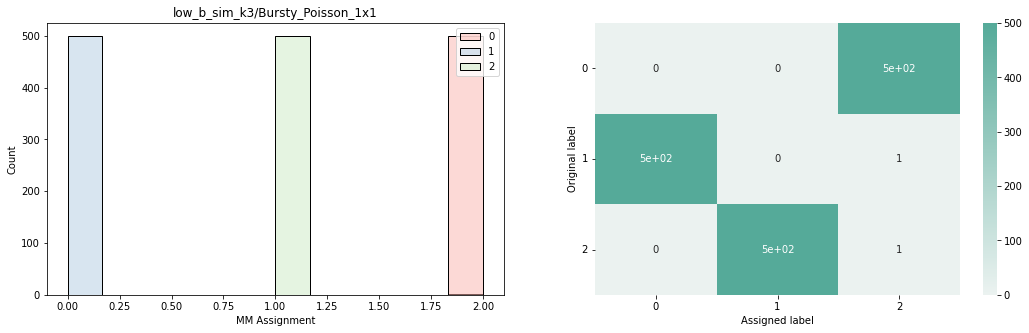

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


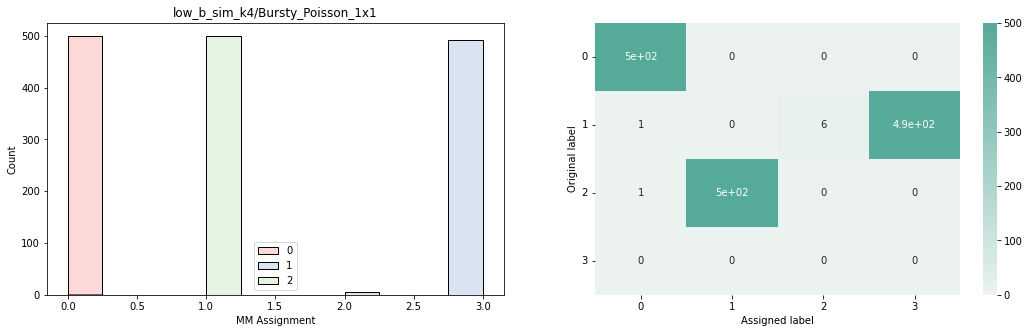

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


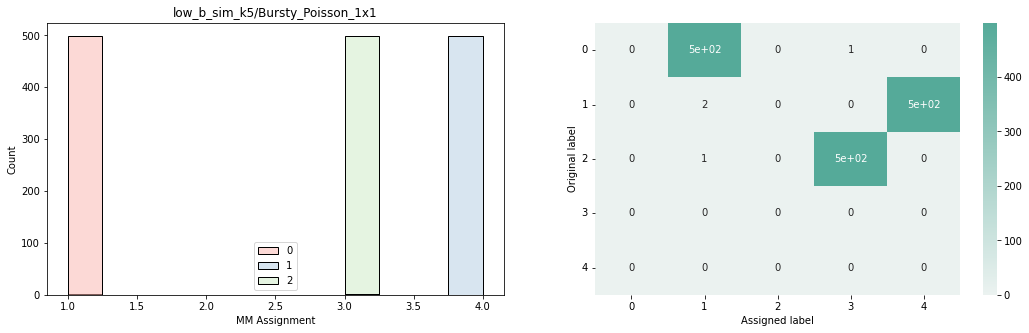

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


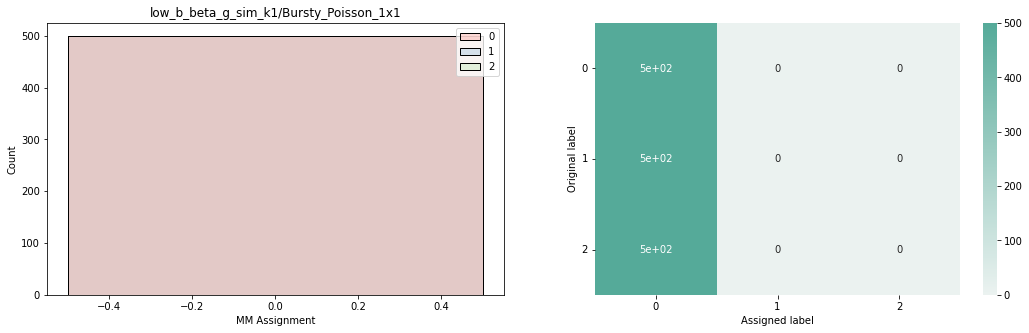

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


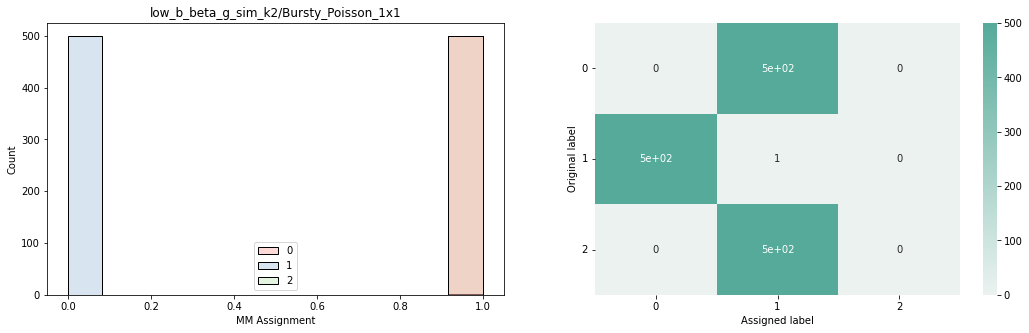

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


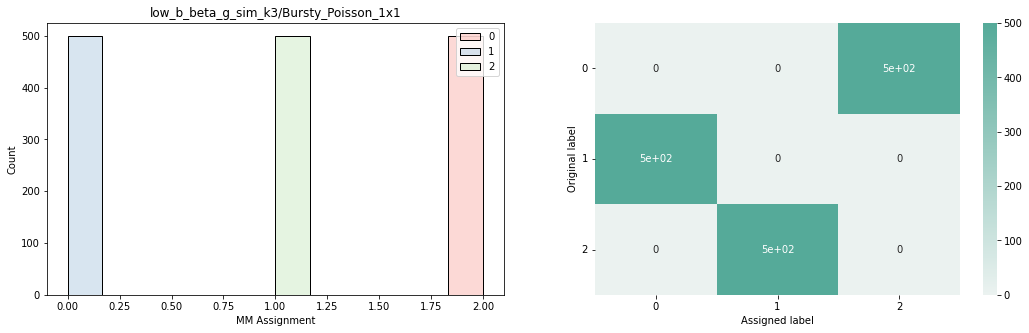

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


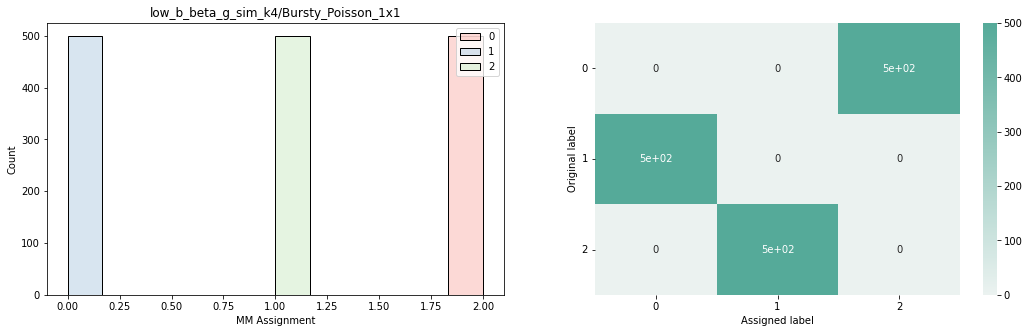

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


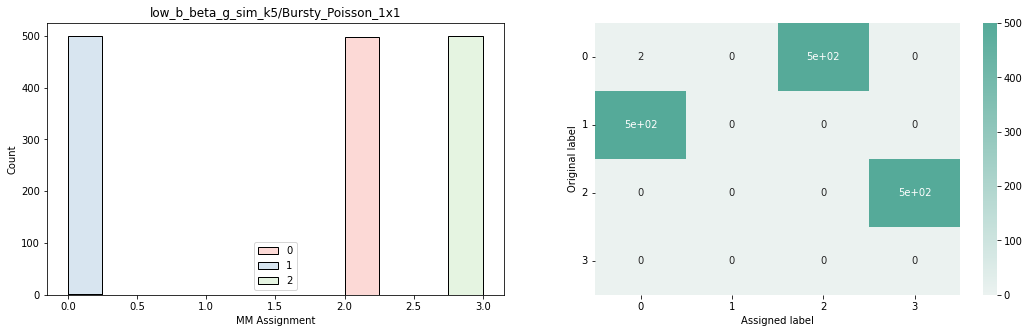

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


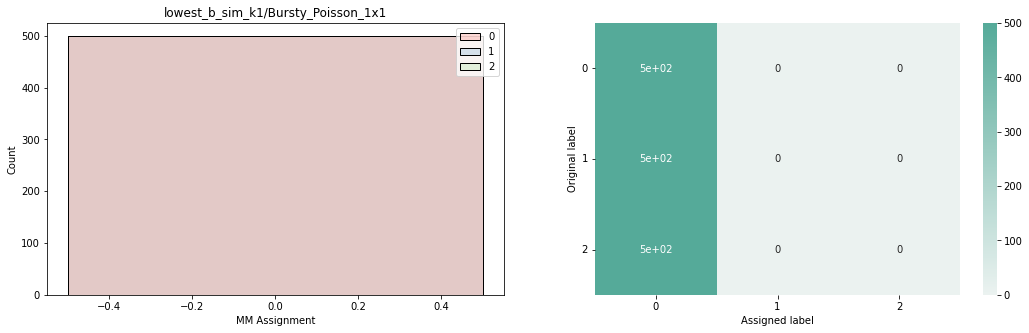

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


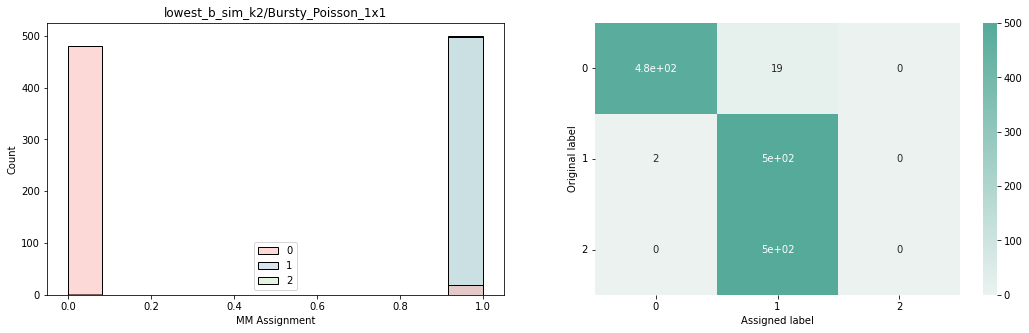

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


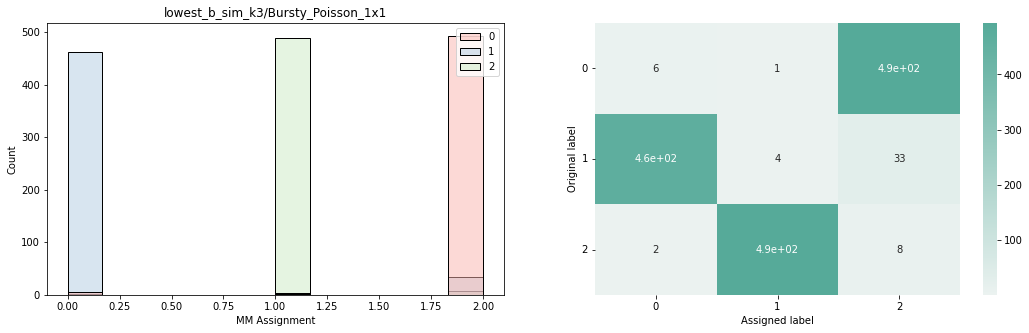

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


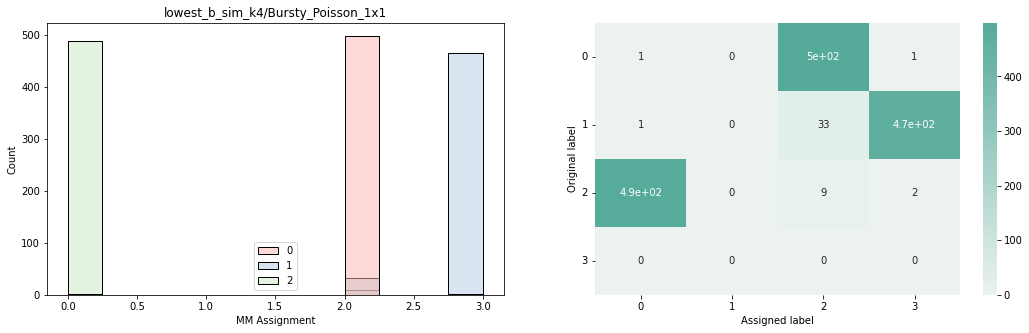

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


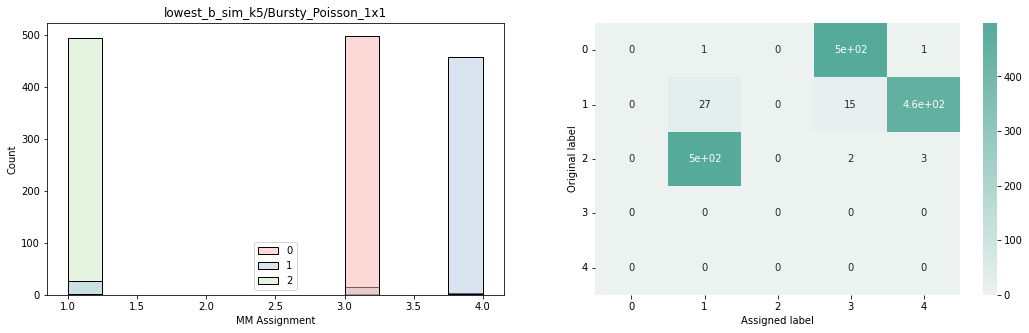

In [43]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230404_025_simTests_MM_1/','')
    vis_assign(np.array(all_assigns),r.assigns,title)


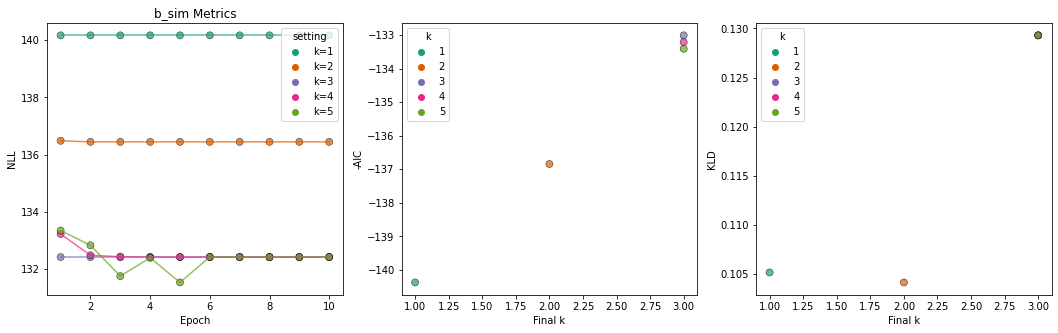

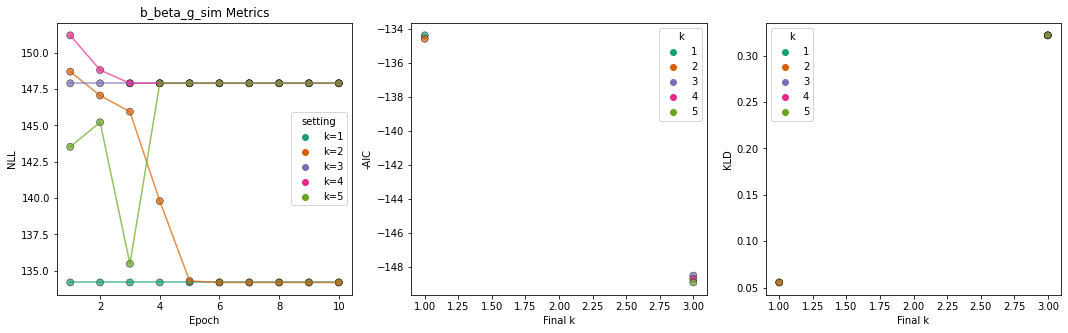

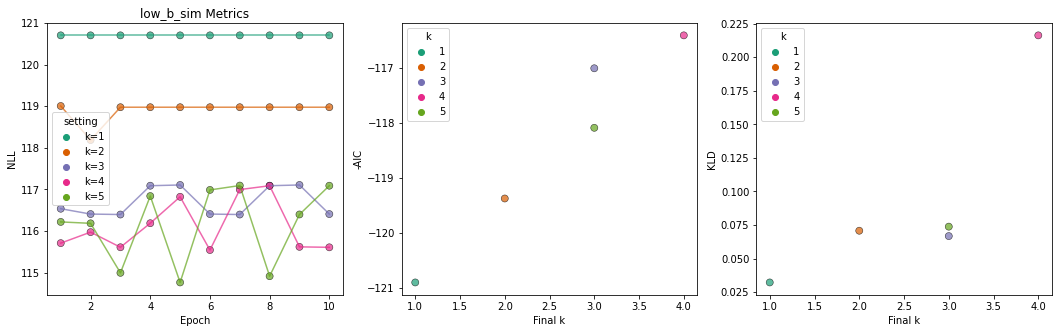

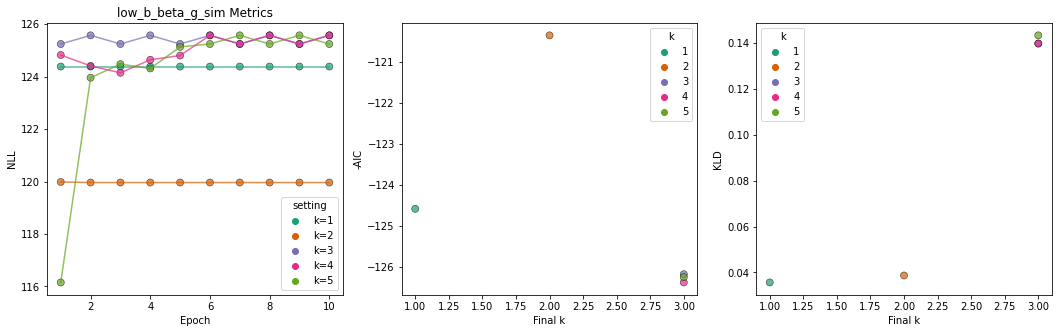

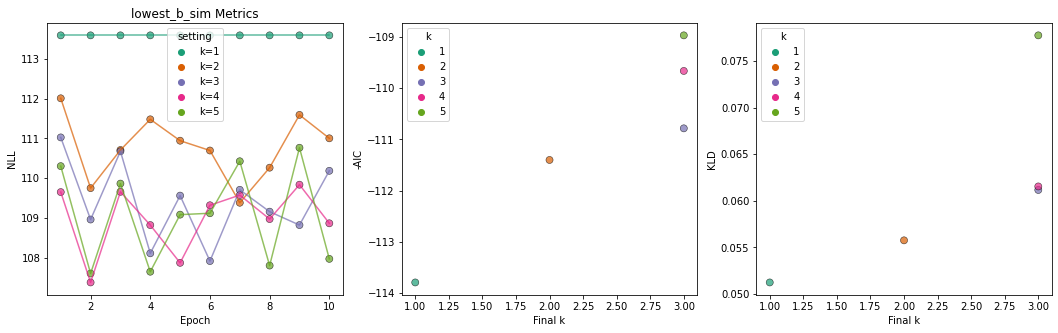

In [52]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)

In [59]:
extra_assigns = grid_point_results[13].assigns
extra_assigns.shape

(1500,)

(array([ 3.,  6., 14., 23., 12., 19.,  9.,  8.,  4.,  2.]),
 array([-0.513245  , -0.28053889, -0.04783279,  0.18487332,  0.41757942,
         0.65028553,  0.88299164,  1.11569774,  1.34840385,  1.58110996,
         1.81381606]),
 <BarContainer object of 10 artists>)

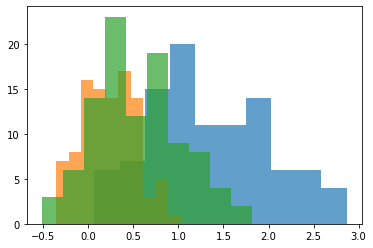

In [61]:
plt.hist(all_params[2][1,:,0],alpha=0.7)
plt.hist(all_params[2][1,:,2],alpha=0.7)
plt.hist(all_params[2][1,:,3],alpha=0.7)

(array([ 4.,  6.,  2.,  3., 22., 31., 24.,  7.,  0.,  1.]),
 array([-1.99999488, -1.37999539, -0.7599959 , -0.13999641,  0.48000307,
         1.10000256,  1.72000205,  2.34000154,  2.96000102,  3.58000051,
         4.2       ]),
 <BarContainer object of 10 artists>)

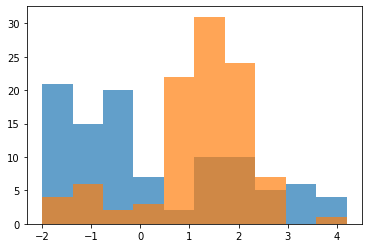

In [71]:
plt.hist(grid_point_results[13].param_estimates[:,0,2],alpha=0.7)
plt.hist(grid_point_results[13].param_estimates[:,0,3],alpha=0.7)

(array([ 9.,  2.,  0.,  8., 42., 31.,  6.,  0.,  1.,  1.]),
 array([-1.8 , -1.37, -0.94, -0.51, -0.08,  0.35,  0.78,  1.21,  1.64,
         2.07,  2.5 ]),
 <BarContainer object of 10 artists>)

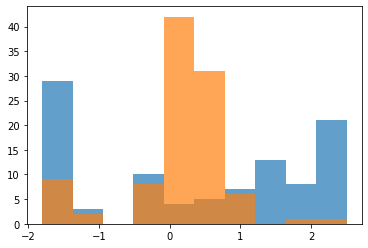

In [70]:
plt.hist(grid_point_results[13].param_estimates[:,1,2],alpha=0.7)
plt.hist(grid_point_results[13].param_estimates[:,1,3],alpha=0.7)

(array([ 8.,  3.,  2.,  1., 10., 19., 24., 18., 12.,  3.]),
 array([-1.8       , -1.42920286, -1.05840572, -0.68760858, -0.31681144,
         0.05398571,  0.42478285,  0.79557999,  1.16637713,  1.53717427,
         1.90797141]),
 <BarContainer object of 10 artists>)

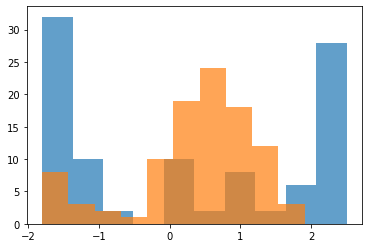

In [69]:
plt.hist(grid_point_results[13].param_estimates[:,2,2],alpha=0.7)
plt.hist(grid_point_results[13].param_estimates[:,2,3],alpha=0.7)

In [ ]:
#old, no spectral init

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


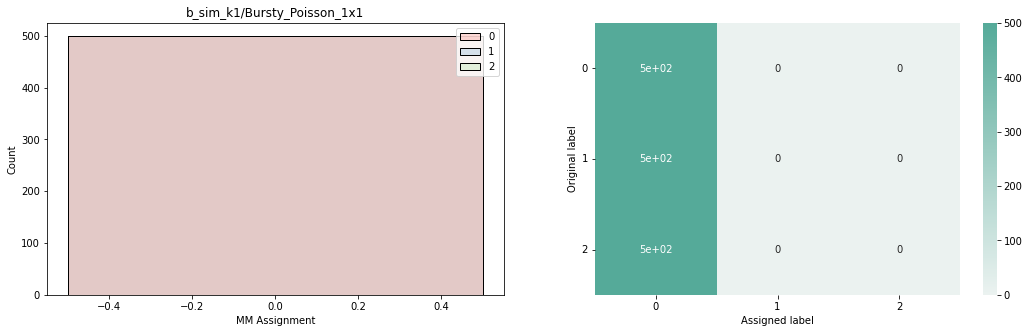

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


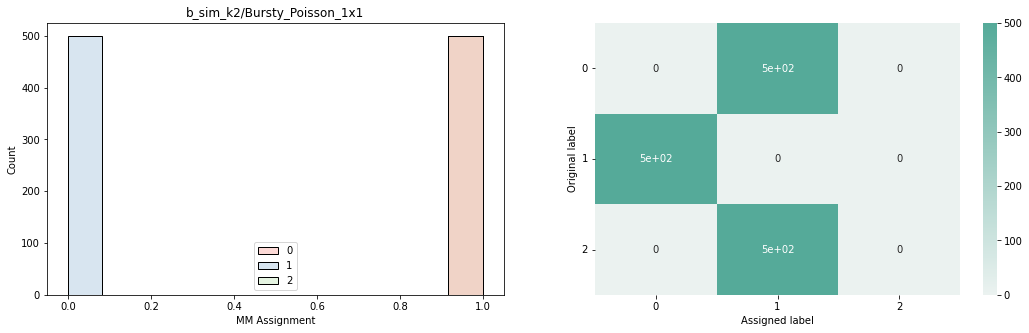

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


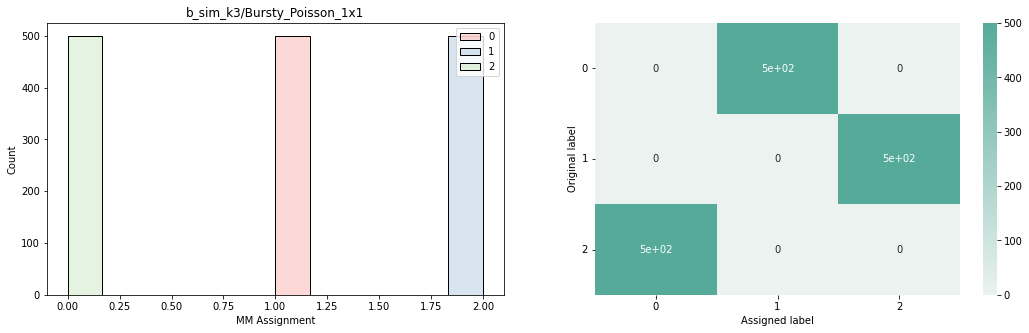

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


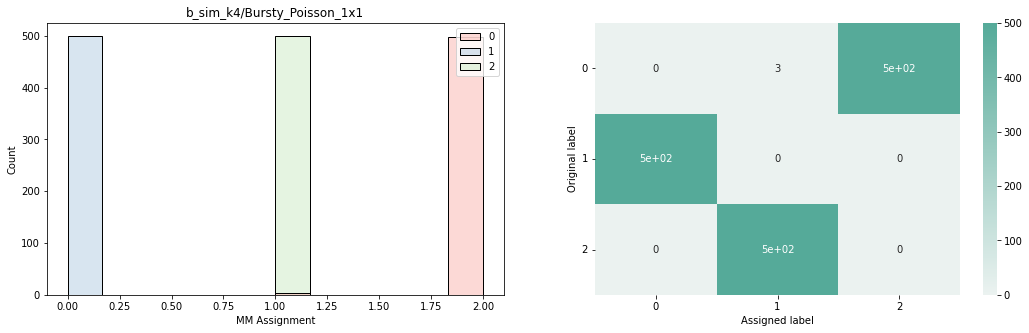

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


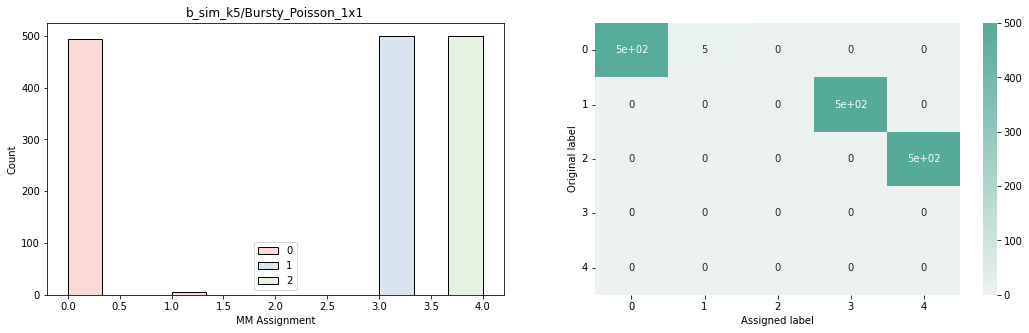

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


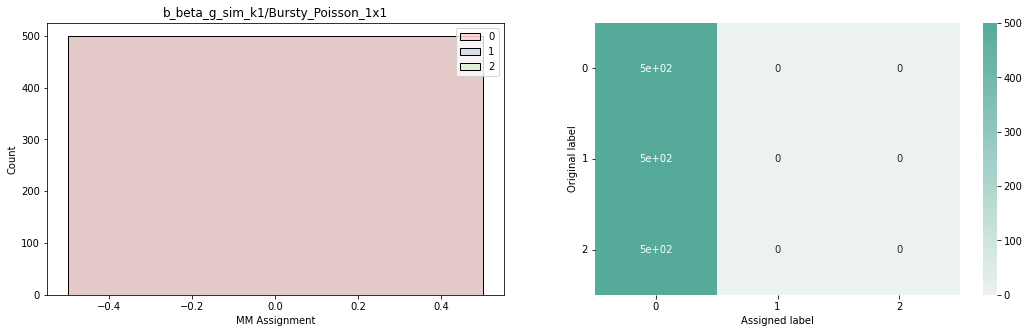

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


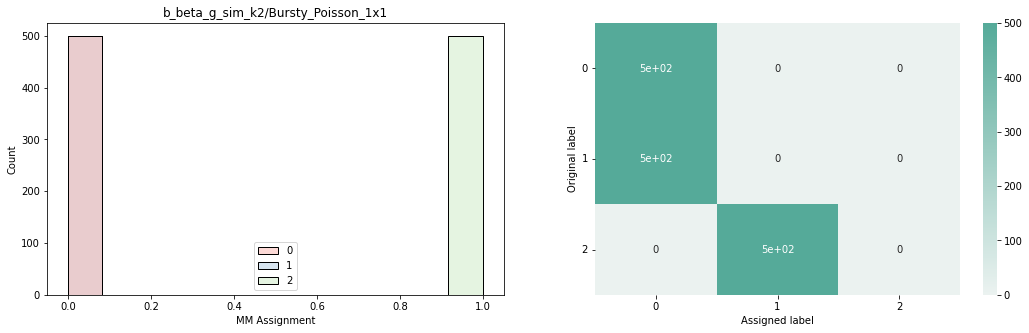

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


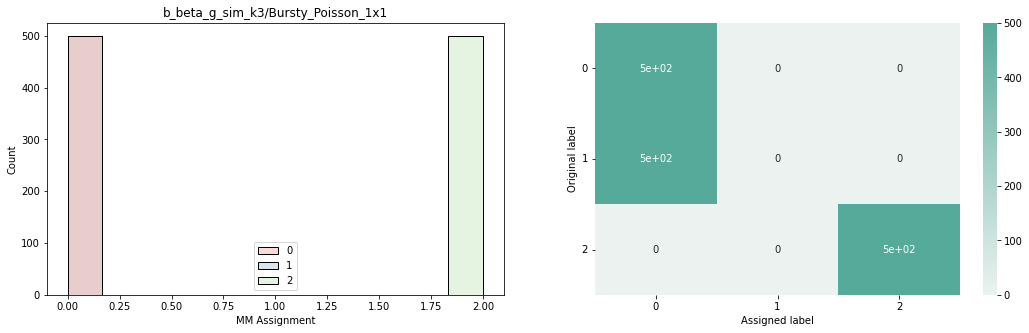

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


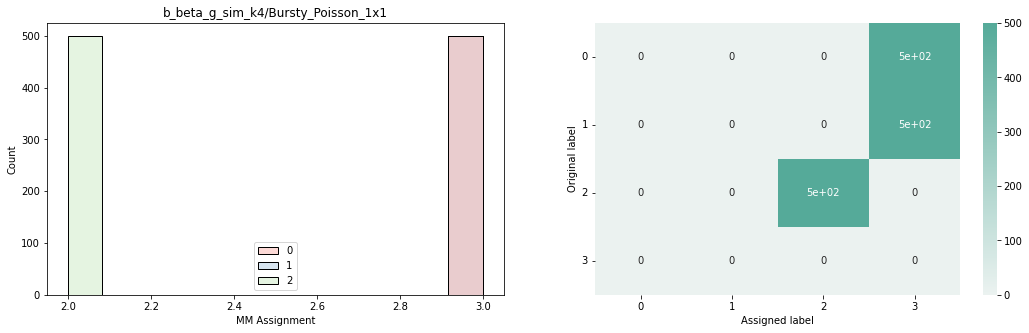

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


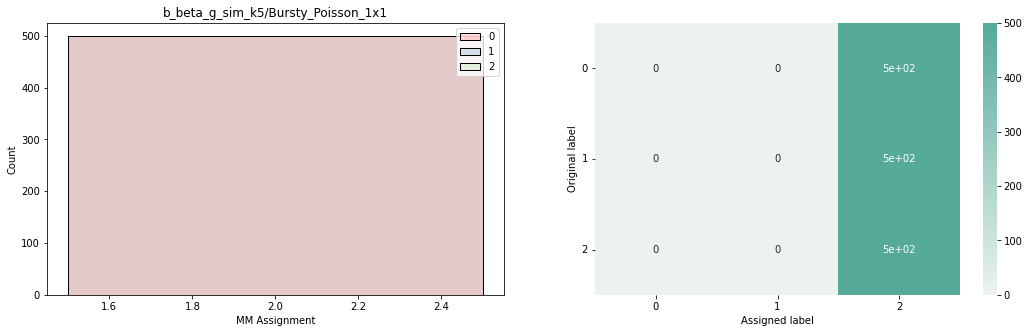

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


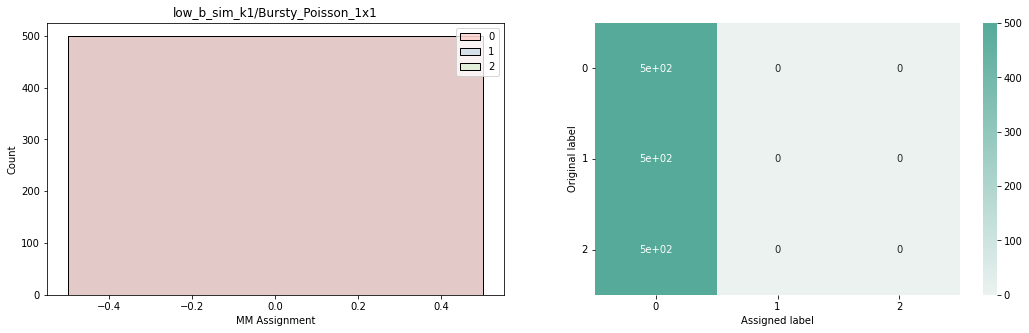

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


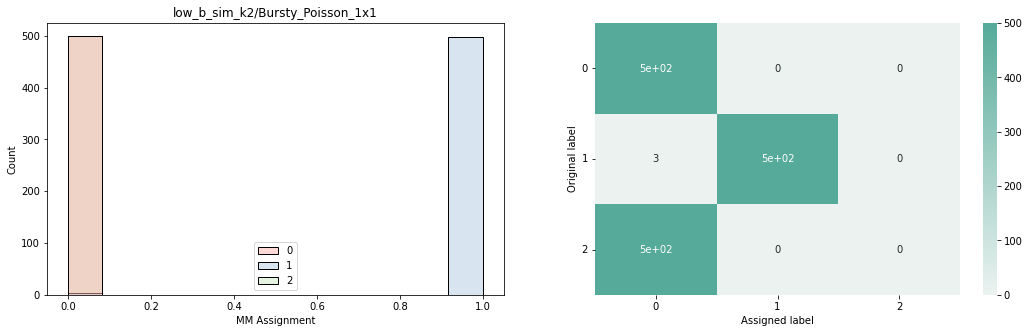

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


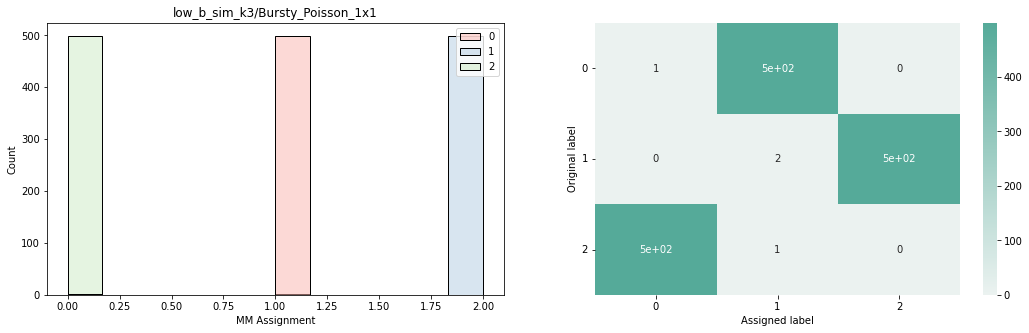

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


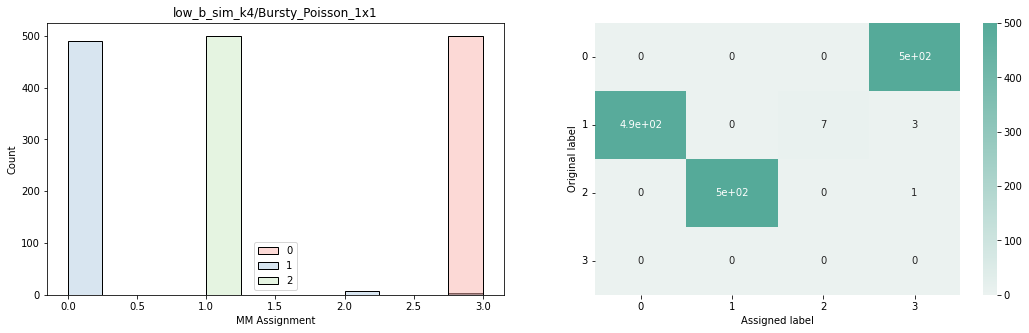

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


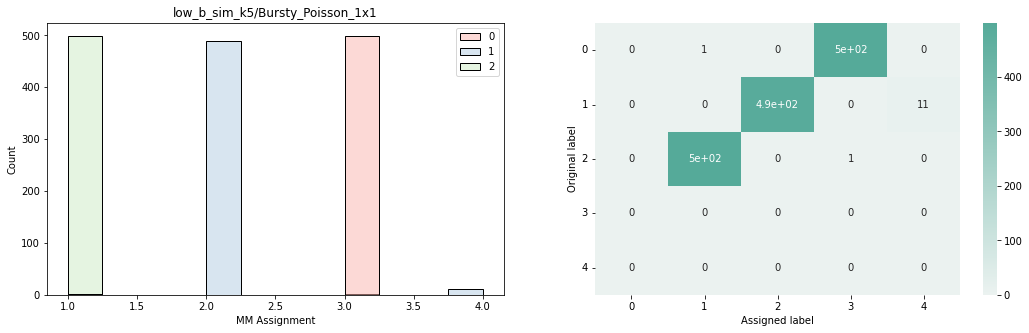

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


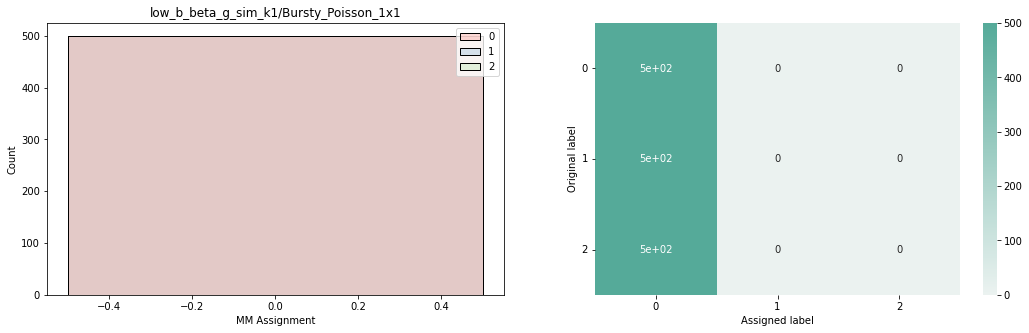

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


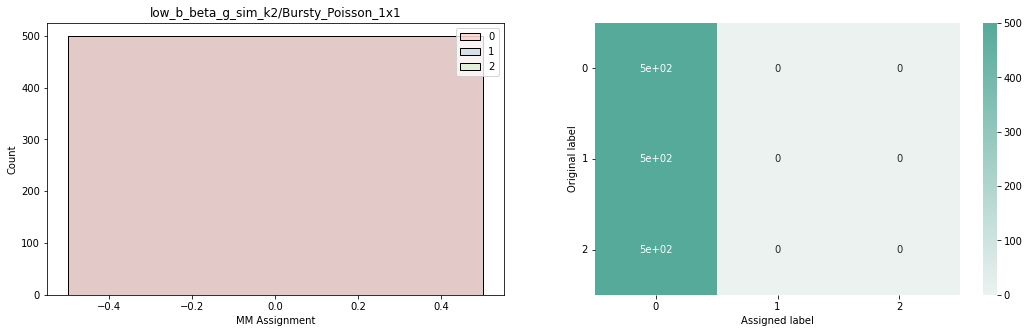

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


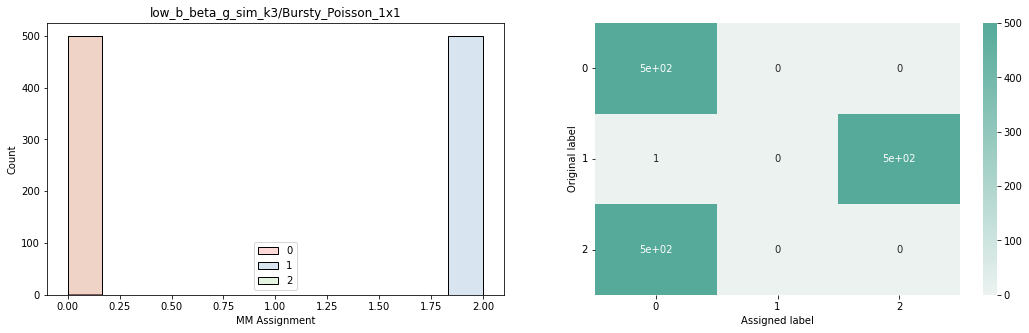

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


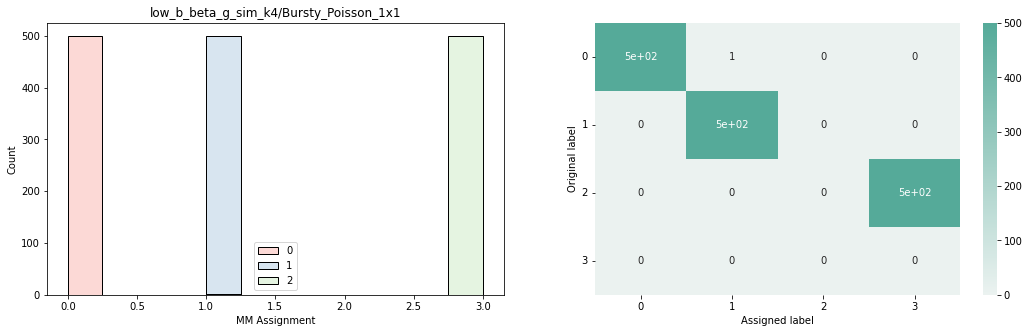

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


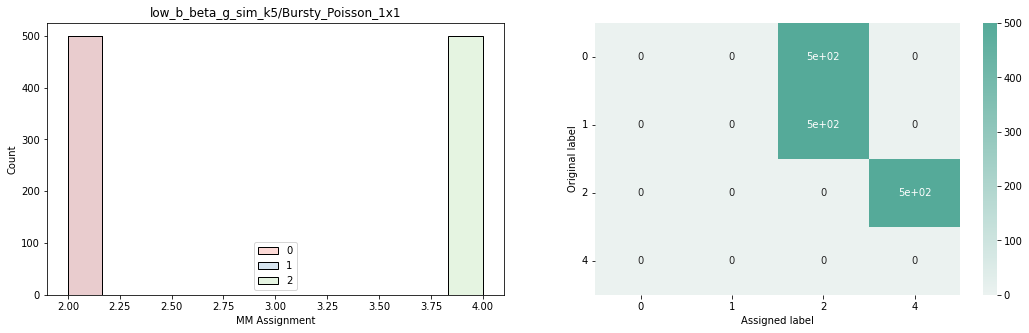

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


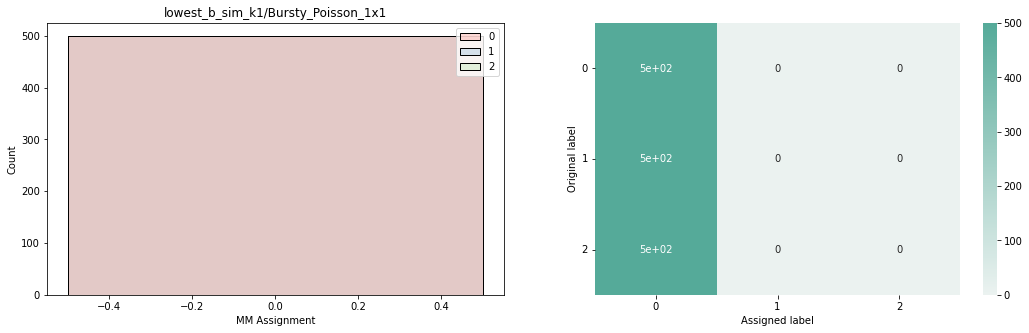

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


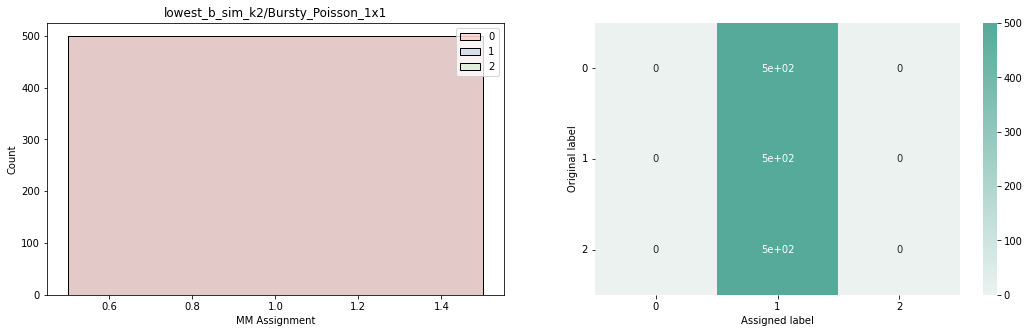

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


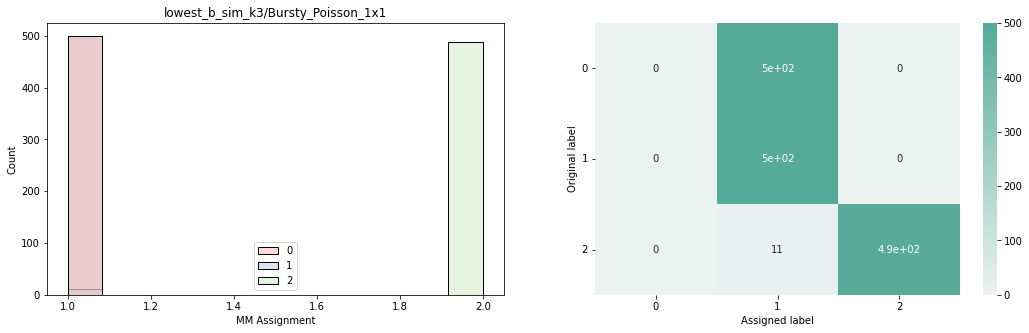

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


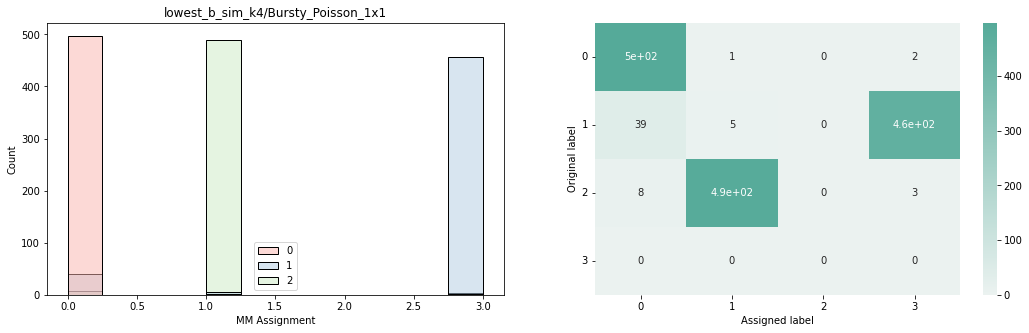

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


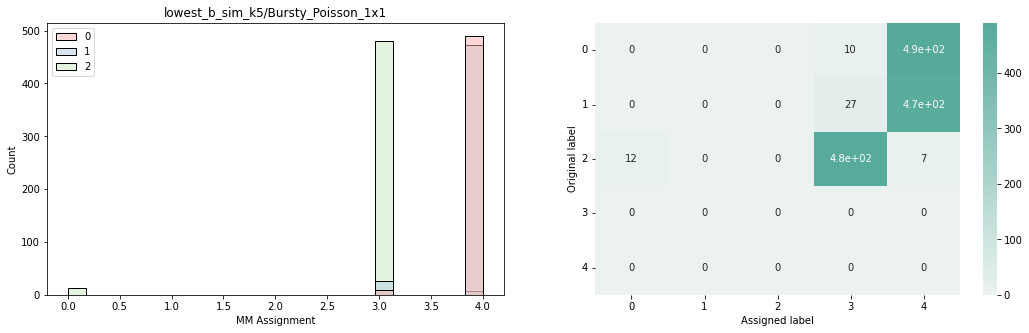

In [371]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230404_025_simTests_MM_1/','')
    vis_assign(np.array(all_assigns),r.assigns,title)


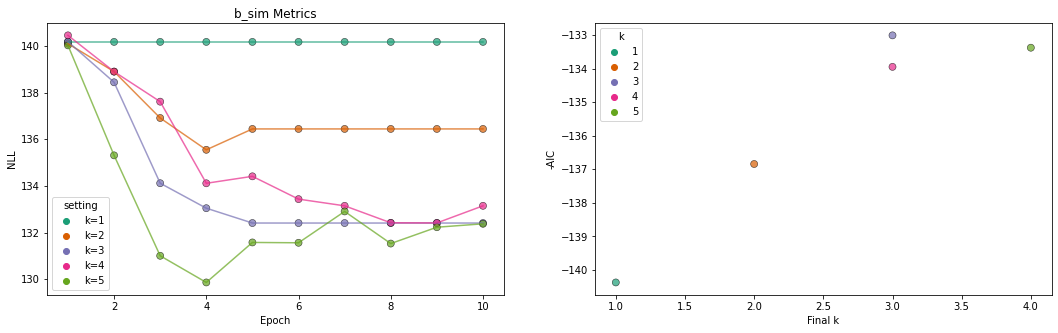

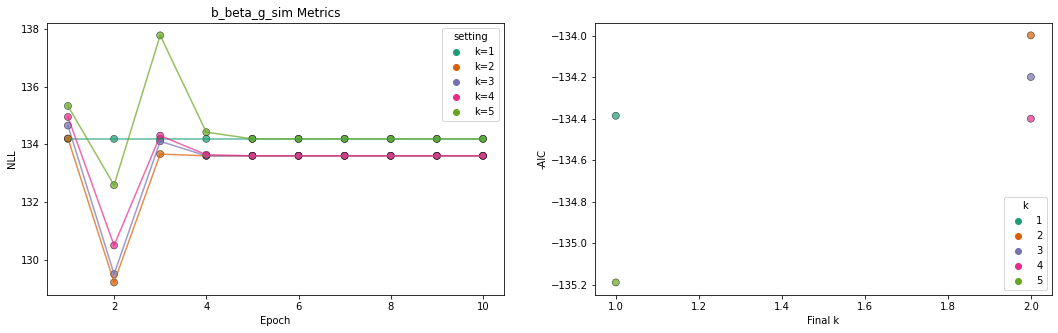

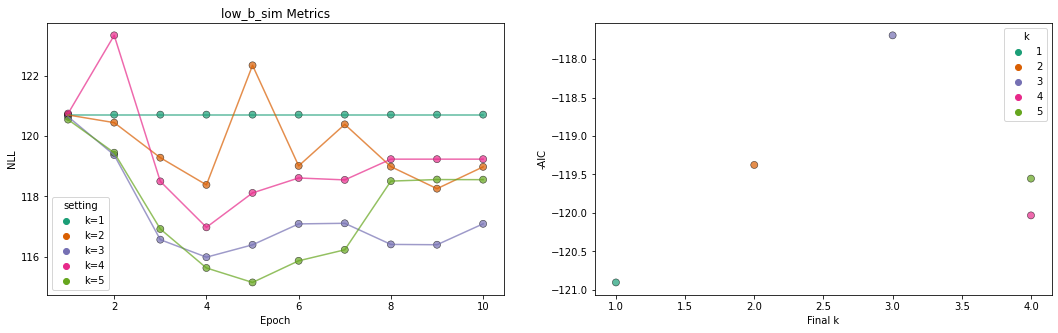

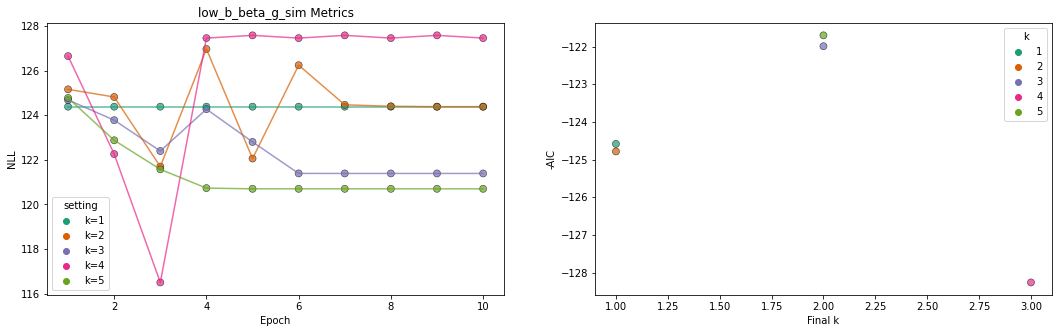

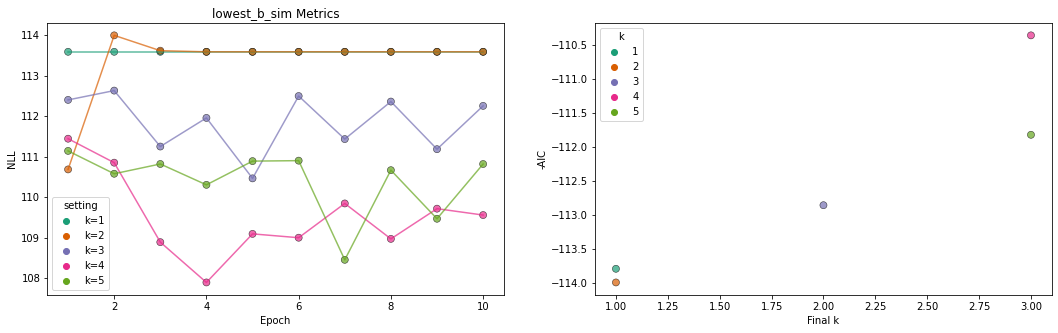

In [372]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)

[0.23657364 0.04572077 0.28761256 0.33333333 0.09675969]


Text(0, 0.5, 'logL')

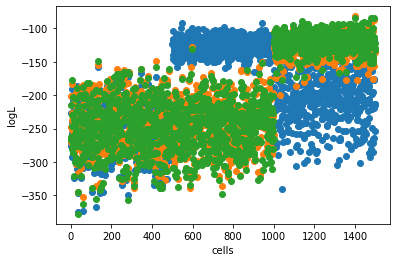

In [294]:
#Plot
select = 4
ws=grid_point_results[select].test_ws
logLs = grid_point_results[select].test_logL
#logLs -= np.log(ws)[None,:]
print(ws)
plt.figure()
plt.scatter(range(len(logLs[:,0])),logLs[:,0])
plt.scatter(range(len(logLs[:,0])),logLs[:,1])
plt.scatter(range(len(logLs[:,0])),logLs[:,2])
# plt.scatter(range(len(logLs[:,0])),logLs[:,3])
# plt.scatter(range(len(logLs[:,0])),logLs[:,4]) #Why one value all cells, not one high value for one cell
plt.xlabel('cells')
plt.ylabel('logL')
#plt.hist(grid_point_results[2].test_logL[:,2])

[Text(1, 0.5, '335'),
 Text(1, 1.5, '387'),
 Text(1, 2.5, '115'),
 Text(1, 3.5, '315'),
 Text(1, 4.5, '133'),
 Text(1, 5.5, '460'),
 Text(1, 6.5, '39'),
 Text(1, 7.5, '360'),
 Text(1, 8.5, '284'),
 Text(1, 9.5, '325'),
 Text(1, 10.5, '134'),
 Text(1, 11.5, '127'),
 Text(1, 12.5, '83'),
 Text(1, 13.5, '396'),
 Text(1, 14.5, '412'),
 Text(1, 15.5, '48'),
 Text(1, 16.5, '439'),
 Text(1, 17.5, '476'),
 Text(1, 18.5, '235'),
 Text(1, 19.5, '415'),
 Text(1, 20.5, '313'),
 Text(1, 21.5, '465'),
 Text(1, 22.5, '311'),
 Text(1, 23.5, '443'),
 Text(1, 24.5, '252'),
 Text(1, 25.5, '35'),
 Text(1, 26.5, '428'),
 Text(1, 27.5, '440'),
 Text(1, 28.5, '16'),
 Text(1, 29.5, '272'),
 Text(1, 30.5, '105'),
 Text(1, 31.5, '448'),
 Text(1, 32.5, '147'),
 Text(1, 33.5, '157'),
 Text(1, 34.5, '34'),
 Text(1, 35.5, '60'),
 Text(1, 36.5, '142'),
 Text(1, 37.5, '125'),
 Text(1, 38.5, '281'),
 Text(1, 39.5, '454'),
 Text(1, 40.5, '180'),
 Text(1, 41.5, '15'),
 Text(1, 42.5, '388'),
 Text(1, 43.5, '47'),
 Text(1

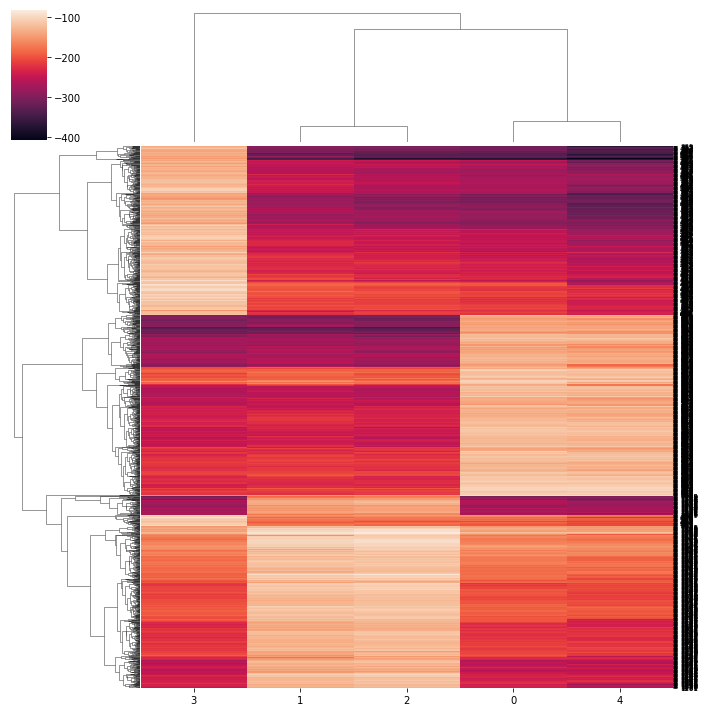

In [295]:
g = sns.clustermap(logLs,yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)

[6.66664825e-01 6.66669830e-10 3.33335173e-01 6.66666665e-10
 6.66666664e-10]


Text(0, 0.5, 'logL')

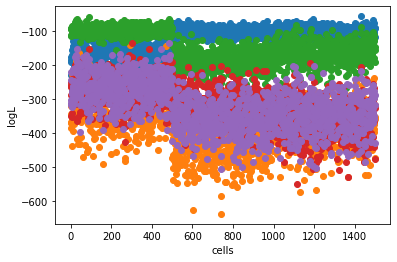

In [97]:
#Plot
select = 4
ws=grid_point_results[select].test_ws
logLs = grid_point_results[select].test_logL
#logLs -= np.log(ws)[None,:]
print(ws)
plt.figure()
plt.scatter(range(len(logLs[:,0])),logLs[:,0])
plt.scatter(range(len(logLs[:,0])),logLs[:,1])
plt.scatter(range(len(logLs[:,0])),logLs[:,2])
plt.scatter(range(len(logLs[:,0])),logLs[:,3])
plt.scatter(range(len(logLs[:,0])),logLs[:,4]) #Why one value all cells, not one high value for one cell
plt.xlabel('cells')
plt.ylabel('logL')
#plt.hist(grid_point_results[2].test_logL[:,2])

In [121]:
Q=np.random.uniform(0,1,size=(100, 3))
Q=Q/Q.sum(axis=(-1),keepdims=True)

### **Compare Monod Fits to Simulation and MM Fits**

In [ ]:
#Check results for burst size > 1

Text(-1, 0.5, '0.7706788606084587')

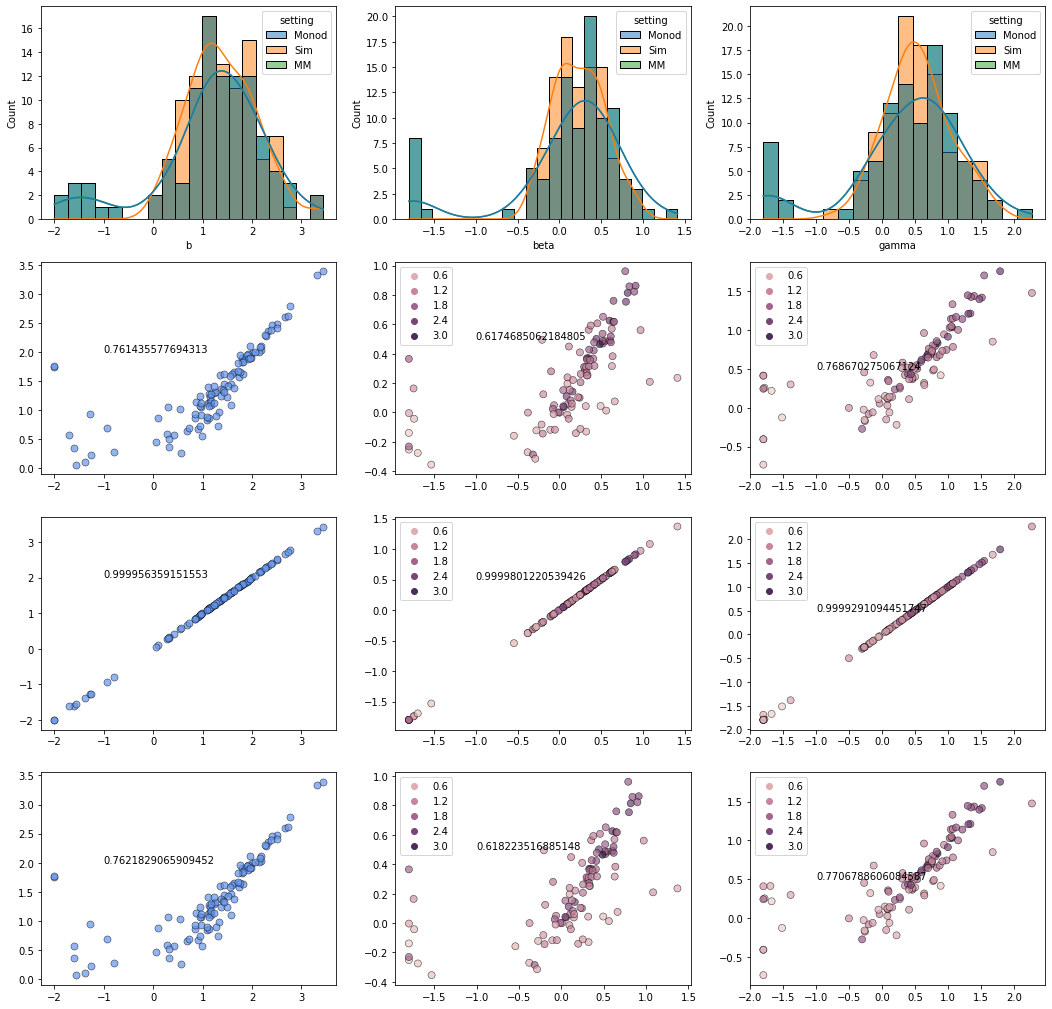

In [47]:
#b_sim
b_sim_monod = sr[0].param_estimates[0]
b_sim_true = all_params[0][0,:,:] #cellxgenex6 -->0,2,3 b,beta,gamma
b_sim_mm = grid_point_results[2].param_estimates[:,:,2]

comps = pd.DataFrame()
comps['b'] = list(b_sim_monod[:,0])+list(b_sim_true[:,0])+list(b_sim_mm[:,0])
comps['beta'] = list(b_sim_monod[:,1])+list(b_sim_true[:,2])+list(b_sim_mm[:,1])
comps['gamma'] = list(b_sim_monod[:,2])+list(b_sim_true[:,3])+list(b_sim_mm[:,2])
comps['setting'] = ['Monod']*n_genes + ['Sim']*n_genes + ['MM']*n_genes


#Plot param histograms
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))

#b,beta,gamma histograms
sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0])
sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1])
sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2])



#Plot correlations
comps_monod = comps[comps.setting.isin(['Monod'])]
comps_true = comps[comps.setting.isin(['Sim'])]
comps_mm = comps[comps.setting.isin(['MM'])]
sns.scatterplot(x=list(comps_monod['b']),y=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,0])
ax[1,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),y=list(comps_true['b']))[0,1])

sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,1])
ax[1,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),y=list(comps_true['beta']))[0,1])


sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,2])
ax[1,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),y=list(comps_true['gamma']))[0,1])



#monod v mm
sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,0])
ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),y=list(comps_mm['b']))[0,1])

sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,1])
ax[2,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),y=list(comps_mm['beta']))[0,1])


sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,2])
ax[2,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),y=list(comps_mm['gamma']))[0,1])


#mm v true
sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,0])
ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),y=list(comps_true['b']))[0,1])

sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,1])
ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),y=list(comps_true['beta']))[0,1])


sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,2])
ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),y=list(comps_true['gamma']))[0,1])

Text(-1, 0.5, '0.8065573888638804')

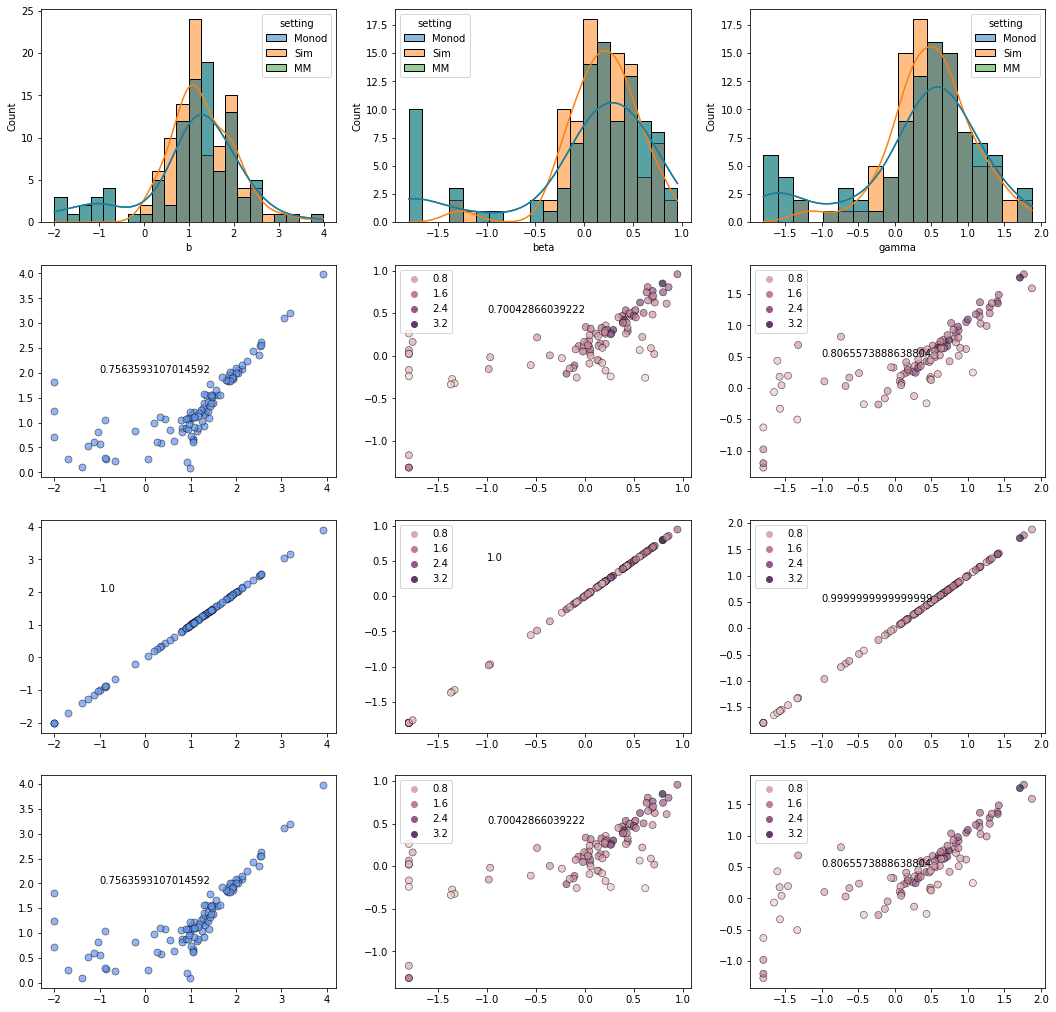

In [48]:
#b_sim
b_sim_monod = sr[1].param_estimates[0]
b_sim_true = all_params[1][0,:,:] #cellxgenex6 -->0,2,3 b,beta,gamma
b_sim_mm = grid_point_results[7].param_estimates[:,:,2]

comps = pd.DataFrame()
comps['b'] = list(b_sim_monod[:,0])+list(b_sim_true[:,0])+list(b_sim_mm[:,0])
comps['beta'] = list(b_sim_monod[:,1])+list(b_sim_true[:,2])+list(b_sim_mm[:,1])
comps['gamma'] = list(b_sim_monod[:,2])+list(b_sim_true[:,3])+list(b_sim_mm[:,2])
comps['setting'] = ['Monod']*n_genes + ['Sim']*n_genes + ['MM']*n_genes


#Plot param histograms
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))

#b,beta,gamma histograms
sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0])
sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1])
sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2])



#Plot correlations
comps_monod = comps[comps.setting.isin(['Monod'])]
comps_true = comps[comps.setting.isin(['Sim'])]
comps_mm = comps[comps.setting.isin(['MM'])]
sns.scatterplot(x=list(comps_monod['b']),y=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,0])
ax[1,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),y=list(comps_true['b']))[0,1])

sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,1])
ax[1,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),y=list(comps_true['beta']))[0,1])


sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,2])
ax[1,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),y=list(comps_true['gamma']))[0,1])



#monod v mm
sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,0])
ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),y=list(comps_mm['b']))[0,1])

sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,1])
ax[2,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),y=list(comps_mm['beta']))[0,1])


sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,2])
ax[2,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),y=list(comps_mm['gamma']))[0,1])


#mm v true
sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,0])
ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),y=list(comps_true['b']))[0,1])

sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,1])
ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),y=list(comps_true['beta']))[0,1])


sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,2])
ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),y=list(comps_true['gamma']))[0,1])


In [ ]:
#Plot mean correlations
k1 = all_counts[0][0:500,:,:]
u_means = np.mean(k1[:,:,0],axis=0)
s_means = np.mean(k1[:,:,1],axis=0)

u_monod = 
s_monod =

u_mm = 
s_mm =



In [ ]:
pred_mean = (sr.param_estimates[0][:,0]-sr.param_estimates[0][:,1])+all_params[0][0,:,4]
plt.scatter(np.log10(np.mean(k1[:,:,0],axis=0)),pred_mean)

(array([86.,  4.,  2.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  2.]),
 array([1.76226851e-06, 3.63687167e-04, 7.25612065e-04, 1.08753696e-03,
        1.44946186e-03, 1.81138676e-03, 2.17331166e-03, 2.53523656e-03,
        2.89716146e-03, 3.25908635e-03, 3.62101125e-03, 3.98293615e-03,
        4.34486105e-03, 4.70678595e-03, 5.06871084e-03, 5.43063574e-03]),
 <BarContainer object of 15 artists>)

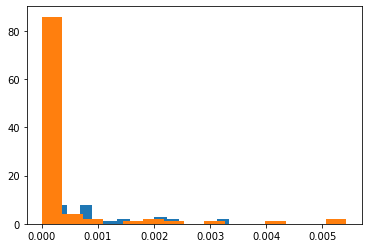

In [865]:
plt.hist(grid_point_results[0].klds[:,0]/grid_point_results[0].klds[:,0].shape[0],bins=15)
#plt.hist(grid_point_results[1].klds[:,0]/grid_point_results[1].klds[:,0].shape[0],bins=15)
plt.hist(grid_point_results[2].klds[:,0]/grid_point_results[2].klds[:,0].shape[0],bins=15)

Text(0, 0.5, 'NLL')

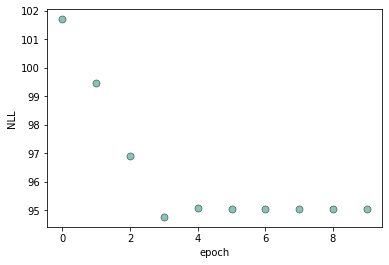

In [858]:
sns.scatterplot(x=range(len(grid_point_results[2].all_bounds)),y=-1*np.array(grid_point_results[2].all_bounds),
            alpha=0.7,s=50,edgecolor='black',color='#5A9')
plt.xlabel('epoch')
plt.ylabel('NLL')

In [635]:
grid_point_results_k3.aic #Compare with k = 2

-94.30739623744375

In [636]:
#Compare parameter fits, gene x param x k to simulated params
grid_point_results_k3.param_estimates.shape

(100, 3, 3)

In [638]:
pred_b0 = grid_point_results_k3.param_estimates[:,0,2]
pred_b1 = grid_point_results_k3.param_estimates[:,0,1]

In [639]:
pred_b0.shape

(100,)

In [640]:
#pred_b0 = np.log10((lens_sub*10**(-7.157894736842105))*(10**(pred_b0) + 1)) #/ samp[0] - 1

In [641]:
true_b0 = params[0,:,0]
true_b1 = params[1,:,0]

(array([ 2.,  7., 10., 20., 18., 23.,  9.,  5.,  1.,  5.]),
 array([-0.44154022, -0.09843812,  0.24466398,  0.58776608,  0.93086818,
         1.27397027,  1.61707237,  1.96017447,  2.30327657,  2.64637867,
         2.98948077]),
 <BarContainer object of 10 artists>)

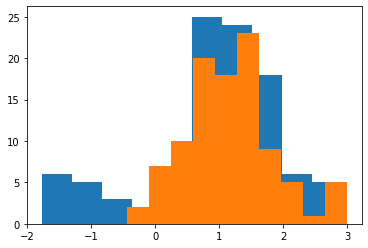

In [643]:
plt.hist(pred_b0)
plt.hist(true_b0)

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


array([[1.        , 0.79137225],
       [0.79137225, 1.        ]])

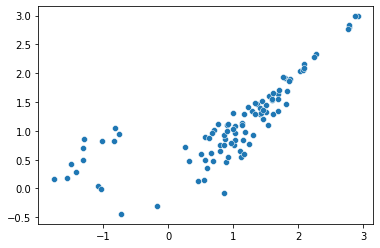

In [645]:
sns.scatterplot(pred_b0,true_b0)
np.corrcoef(pred_b0,true_b0)

### **Compare params to control Monod, single-cluster test**

In [776]:
sr.param_estimates[0].shape

(100, 3)

In [778]:
true_b0 = all_params[0][0,:,0]

In [780]:
k1 = all_counts[0][0:500,:,:]
k1.shape

(500, 100, 2)

[[1.         0.99994398]
 [0.99994398 1.        ]]


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'fit mean U')

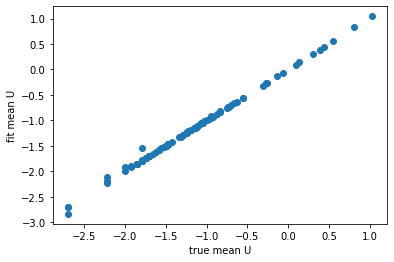

In [781]:
pred_mean = (sr.param_estimates[0][:,0]-sr.param_estimates[0][:,1])+all_params[0][0,:,4]
plt.scatter(np.log10(np.mean(k1[:,:,0],axis=0)),pred_mean)
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**pred_mean))

plt.xlabel('true mean U')
plt.ylabel('fit mean U')

[[nan nan]
 [nan  1.]]


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Fit Fano - 1')

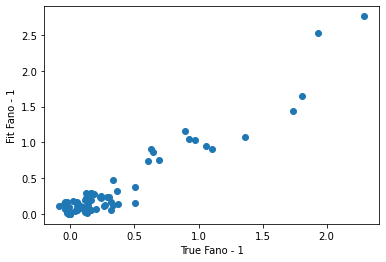

In [532]:
fano = np.var(k1[:,:,0],axis=0)/np.mean(k1[:,:,0],axis=0) - 1
pred_fano = 10**(params[0,:,4])*(1+10**params[0,:,0])

plt.scatter(fano,pred_fano)
print(np.corrcoef(fano,pred_fano))

plt.xlabel('True Fano - 1')
plt.ylabel('Fit Fano - 1')

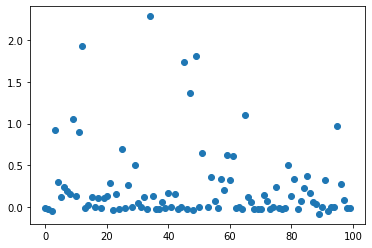

In [533]:
plt.scatter(range(len(fano)),fano)

(array([ 2.,  5.,  5., 14., 21., 17., 17., 10.,  3.,  6.]),
 array([-0.44154022, -0.14843812,  0.14466398,  0.43776608,  0.73086818,
         1.02397027,  1.31707237,  1.61017447,  1.90327657,  2.19637867,
         2.48948077]),
 <BarContainer object of 10 artists>)

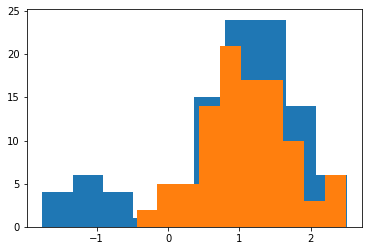

In [588]:
#Monod b dist overlap with true b dist
plt.hist(sr.param_estimates[0][:,0]) #Monod also not getting params right without EM
plt.hist(true_b0)

array([[1.        , 0.94245049],
       [0.94245049, 1.        ]])

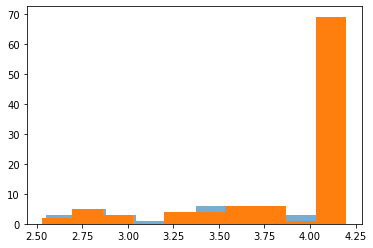

In [257]:
pred_b0 = grid_point_results[0].param_estimates[:,0,0]
plt.hist(sr.param_estimates[0][:,0],alpha=0.6)
plt.hist(pred_b0)
np.corrcoef(sr.param_estimates[0][:,0],pred_b0)

array([[1.        , 0.87494348],
       [0.87494348, 1.        ]])

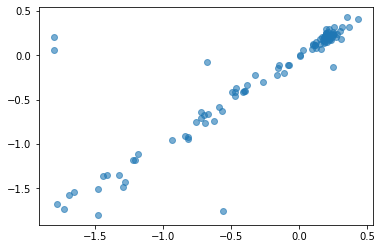

In [258]:
pred_b0 = grid_point_results_k3.param_estimates[:,1,0]
plt.scatter(sr.param_estimates[0][:,1],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,1],pred_b0)

array([[1.        , 0.49130319],
       [0.49130319, 1.        ]])

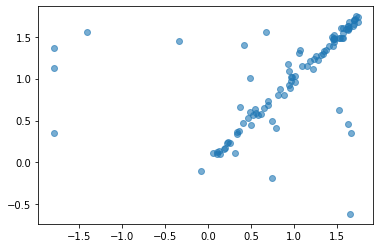

In [259]:
pred_b0 = grid_point_results_k3.param_estimates[:,2,0]
plt.scatter(sr.param_estimates[0][:,2],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,2],pred_b0)

## **MISC**

In [85]:
#Init values per gene

np.random.seed(42)

b=10 #10
k = 0.2 #0.2 
beta = 1 #1
gamma = 0.8 #0.8
samp = [0.008,10**(-1.525)] #[0.4,0.5], from data 10**(-7.157894736842105)*len + 10**(-1.525) 




In [86]:
#Get PSS for gene
p = np.log10(np.asarray([b,beta/k,gamma/k]))
burst_model = BurstModel('Poisson')

max_mean = b*k*np.asarray([1/beta,1/gamma])
max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))
max_domain = max_mean + 4*max_std
max_domain = [int(i) for i in max_domain]

Pss = burst_model.get_Pss(p,max_domain,samp)

#Get samples
test = sample_from_p(100, Pss)


[20, 18]


In [281]:
all_counts.shape

(1500, 100, 2)

In [187]:
all_choices

array([16, 94, 30, 72, 63, 66, 62, 92, 26, 38, 73, 82, 40, 87, 42,  0,  5,
        3, 59, 24, 61, 99, 44, 45, 88, 93, 13, 20, 37, 34])

Text(0, 0.5, 'Mature counts')

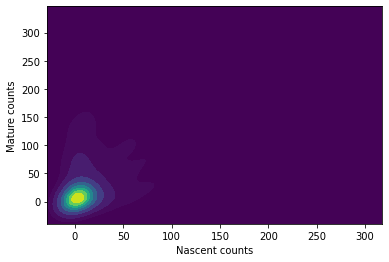

In [305]:
plt.figure()
test = all_counts[:,0]
sns.kdeplot(x=test[:,0], y=test[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [331]:

concat_types = np.concatenate((np.mean(all_counts[0:500,:,:],axis=0),np.mean(all_counts[500:1000,:,:],axis=0),
          np.mean(all_counts[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '74'),
 Text(1, 1.5, '15'),
 Text(1, 2.5, '48'),
 Text(1, 3.5, '11'),
 Text(1, 4.5, '33'),
 Text(1, 5.5, '94'),
 Text(1, 6.5, '40'),
 Text(1, 7.5, '86'),
 Text(1, 8.5, '19'),
 Text(1, 9.5, '73'),
 Text(1, 10.5, '27'),
 Text(1, 11.5, '96'),
 Text(1, 12.5, '17'),
 Text(1, 13.5, '69'),
 Text(1, 14.5, '45'),
 Text(1, 15.5, '65'),
 Text(1, 16.5, '36'),
 Text(1, 17.5, '88'),
 Text(1, 18.5, '0'),
 Text(1, 19.5, '4'),
 Text(1, 20.5, '12'),
 Text(1, 21.5, '13'),
 Text(1, 22.5, '39'),
 Text(1, 23.5, '67'),
 Text(1, 24.5, '82'),
 Text(1, 25.5, '58'),
 Text(1, 26.5, '81'),
 Text(1, 27.5, '85'),
 Text(1, 28.5, '53'),
 Text(1, 29.5, '60'),
 Text(1, 30.5, '42'),
 Text(1, 31.5, '46'),
 Text(1, 32.5, '24'),
 Text(1, 33.5, '43'),
 Text(1, 34.5, '7'),
 Text(1, 35.5, '41'),
 Text(1, 36.5, '10'),
 Text(1, 37.5, '57'),
 Text(1, 38.5, '83'),
 Text(1, 39.5, '5'),
 Text(1, 40.5, '50'),
 Text(1, 41.5, '80'),
 Text(1, 42.5, '25'),
 Text(1, 43.5, '54'),
 Text(1, 44.5, '37'),
 Text(1, 45.5, '56'),
 T

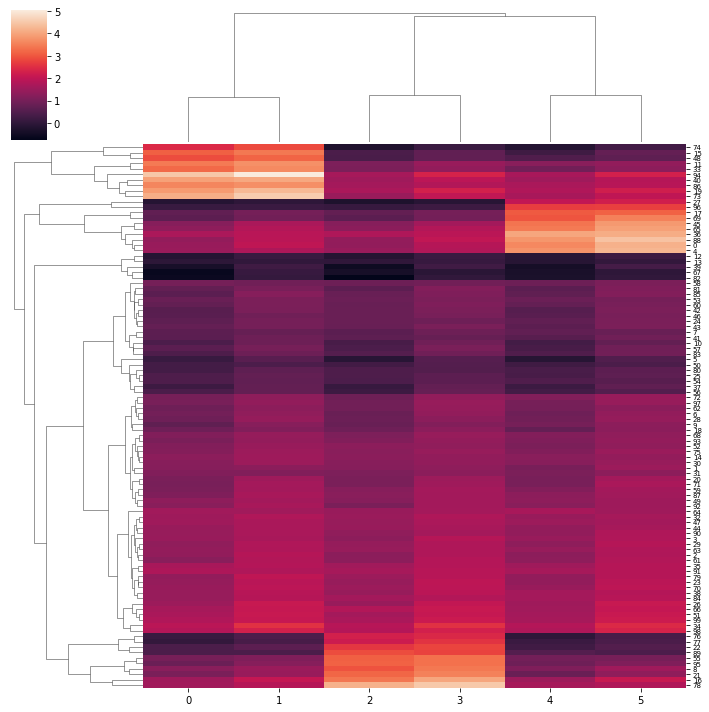

In [343]:
#Make heatmap with markers

g = sns.clustermap(np.log(concat_types),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)


[Text(1, 0.5, '94'),
 Text(1, 1.5, '78'),
 Text(1, 2.5, '73'),
 Text(1, 3.5, '19'),
 Text(1, 4.5, '40'),
 Text(1, 5.5, '45'),
 Text(1, 6.5, '65'),
 Text(1, 7.5, '36'),
 Text(1, 8.5, '88'),
 Text(1, 9.5, '0'),
 Text(1, 10.5, '4'),
 Text(1, 11.5, '11'),
 Text(1, 12.5, '86'),
 Text(1, 13.5, '15'),
 Text(1, 14.5, '33'),
 Text(1, 15.5, '69'),
 Text(1, 16.5, '17'),
 Text(1, 17.5, '96'),
 Text(1, 18.5, '48'),
 Text(1, 19.5, '74'),
 Text(1, 20.5, '76'),
 Text(1, 21.5, '77'),
 Text(1, 22.5, '22'),
 Text(1, 23.5, '89'),
 Text(1, 24.5, '34'),
 Text(1, 25.5, '98'),
 Text(1, 26.5, '26'),
 Text(1, 27.5, '66'),
 Text(1, 28.5, '51'),
 Text(1, 29.5, '99'),
 Text(1, 30.5, '27'),
 Text(1, 31.5, '7'),
 Text(1, 32.5, '41'),
 Text(1, 33.5, '57'),
 Text(1, 34.5, '10'),
 Text(1, 35.5, '83'),
 Text(1, 36.5, '58'),
 Text(1, 37.5, '53'),
 Text(1, 38.5, '60'),
 Text(1, 39.5, '24'),
 Text(1, 40.5, '42'),
 Text(1, 41.5, '43'),
 Text(1, 42.5, '46'),
 Text(1, 43.5, '81'),
 Text(1, 44.5, '85'),
 Text(1, 45.5, '12'),
 

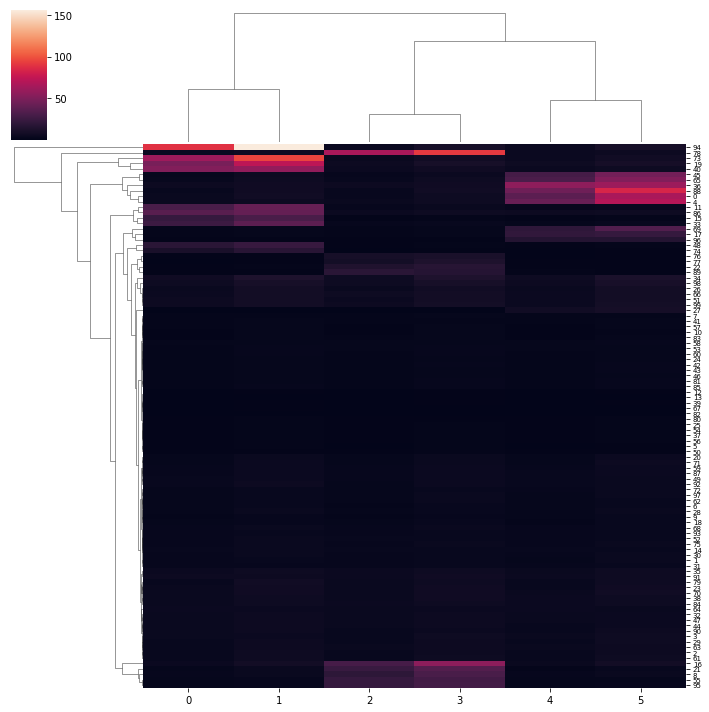

In [344]:
g = sns.clustermap(concat_types,yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)
